# Non-Attending Class Project

The project is designed to let you apply all parts of the class covered in the material, and demonstrate that you have mastered it. The submission will be graded on the correctness and performance of the execution of your analysis (50%), the ambitiousness of the problems chosen (30%), and the creativity of your questions and solutions (20%).

Your submission should include all outputs and be self-contained, so it can be executed if necessary.

# 1. Research Question(s) (2 pts)

*Describe what question you are investigating with the data (max. 100 words)*

In the past years we have seen a surge of applications of NLP techniques to make inference on mental health status from online text, but relatively little work has been done in distinguishing between several mental health conditions and assessing the severity. 

My goal is to analyze textual data from Reddit in order to classify the posts not only as a binary classification problem (healthy vs non-healthy), but also to understand the type of condition and possibly the severity, introducing a specific label for the risk of suicide.


# 2. Data, Preprocessing, and Annotation (3 pts)

*Find a data set for text classification and a data set for structured prediction. These can be the same.
Kaggle is a good place to start, or the Google data set search.*

*The data sets should have **at least 5,000** documents each. **At least 2000 instances** need to be labeled. If there is no label provided, you can annotate your own. You can get up to **2 bonus points** for annotation, depending on the amount and complexity of the annotation.*

*Split the data into dedicated training, development, and test sets (if they do not include these already)!*

*Briefly (max. 100 words!) describe the content and type of the data set, and what you are planning to look at.*
***

I created the dataset using Reddit's PRAW API. <br>

The dataset contains different posts from specific subreddits: 
- r/depression
- r/Anxiety
- r/bipolar
- r/BPD
- r/mentalhealth
- r/SuicideWatch
- r/CasualConversation. 

I used the subreddits as the labels for the posts. 

Each subreddit is supposed to represent a specific condition, with the exception of r/mentalhealth which contains general discussions concerning, you guessed, mental health. <br>
The other exception is r/CasualConversation, which I included so that the models are fed also different kind of data.<br> This is important for generalization purposes on unseen data.
***

*Preprocess the data and explain (max. 200 words) which preprocessing steps you chose and why, and give statistics of the number of documents, types, and tokens, before and after preprocessing.*

***

First, before the preprocessing step, I explored the data looking for missing values. In this way, I managed to clean the data, imputing values where it made sense and removing observations if the posts where unrelated to the mental health conditions.

As a second step, I cleaned that data from all the Reddit-specific markdown formatting which is included in the textual data returned from the API.

Finally, I preprocessed the data by removing stopwords and punctuation. To further reduce the variability in the data, without losing too much information, I applied lemmatization to the data in two different ways:
1. Standard lemmatization
2. Lemmatization with POS tagging, keeping only NOUNS and ADJ.

After analyzing the results, I decided to use the second approach because it reduces extremely the amount of words, while retaining the meaning of the documents.
***

## 2.1 Data upload

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

from collections import Counter
from collections import defaultdict

In [11]:
df = pd.read_csv('mental_health_data.csv').iloc[:,1:]
df.head()

,title,body,author,url,score,upvote_ratio,subreddit
0,Craving closeness,"About a year ago, I got into a relationship th...",Nash4N00b,https://www.reddit.com/r/mentalhealth/comments...,2,1.00,mentalhealth
1,Mental health class,I think schools should have a mandatory mental...,ConnecticutJohn,https://www.reddit.com/r/mentalhealth/comments...,112,0.97,mentalhealth
2,My 7yo son accidentally fell on our pet bird a...,It was TRULY a freak accident and not expected...,AnonymousCounselor52,https://www.reddit.com/r/mentalhealth/comments...,387,0.97,mentalhealth
3,Who else doesn’t want covid world to leave,My mental health has been so bad and I’ve been...,jjdabest8820,https://www.reddit.com/r/mentalhealth/comments...,15,0.94,mentalhealth
4,my mental health is suffering due to my contro...,note: please read my previous posts for contex...,Wooden_View_7120,https://www.reddit.com/r/mentalhealth/comments...,7,0.83,mentalhealth


In [12]:
df.shape

(6239, 7)

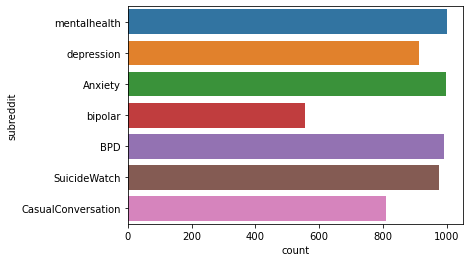

In [13]:
# Countplot by subreddit

sns.countplot(y="subreddit", data=df)

## 2.2 Missing values

In [14]:
# Let's check if there are missing values

df.isna().sum()

title             0
body            316
author           26
url               0
score             0
upvote_ratio      0
subreddit         0
dtype: int64

In [15]:
# When the author is missing is because the account has been cancelled.
# This is not a problem for the analysis.

df[df['author'].isna()].reset_index()['url'][:5]

0    https://www.reddit.com/r/mentalhealth/comments...
1    https://www.reddit.com/r/mentalhealth/comments...
2    https://www.reddit.com/r/mentalhealth/comments...
3    https://www.reddit.com/r/depression/comments/n...
4    https://www.reddit.com/r/depression/comments/n...
Name: url, dtype: object

In [16]:
# How are the missing values for the body feature distribted accross subreddits?
# As we can see, r/bipolar stands out

df[df['body'].isna()].groupby('subreddit').count()['title']

subreddit
Anxiety          20
SuicideWatch     45
bipolar         232
depression        7
mentalhealth     12
Name: title, dtype: int64

In [17]:
# For r/bipolar, the body is missing because most posts are either memes, videos or links to other websites.

df[(df['body'].isna()) & (df['subreddit']=='bipolar')].reset_index()['url'][:5]

0      https://i.redd.it/inr6td85lrw61.jpg
1      https://i.redd.it/6hgatwtv0rw61.jpg
2    https://www.reddit.com/gallery/n3p1t5
3      https://i.redd.it/35rj80rxtqw61.jpg
4      https://i.redd.it/2mirmpc2duw61.jpg
Name: url, dtype: object

In [18]:
# For this subreddit, it is better to delete all data points with missing values for the body feature.
# The same is true for r/mentalhealth.

df = df[~((df['body'].isna()) & (df['subreddit'].isin(['bipolar', 'mentalhealth'])))].reset_index().drop('index', axis=1)

In [19]:
# For r/SuicideWatch the situation is different: the body is missing simply because the author decided to write only the title.
# Another reason is because the post has been deleted by the author.

df[(df['body'].isna()) & (df['subreddit']=='SuicideWatch')].reset_index()['url'][:5]

0    https://www.reddit.com/r/SuicideWatch/comments...
1    https://www.reddit.com/r/SuicideWatch/comments...
2    https://www.reddit.com/r/SuicideWatch/comments...
3    https://www.reddit.com/r/SuicideWatch/comments...
4    https://www.reddit.com/r/SuicideWatch/comments...
Name: url, dtype: object

In [20]:
# In this case, instead, it makes sense to retain the data points and treat the title as the full text.
# The same is true for r/Anxiety and r/depression.

df.fillna('', inplace=True)

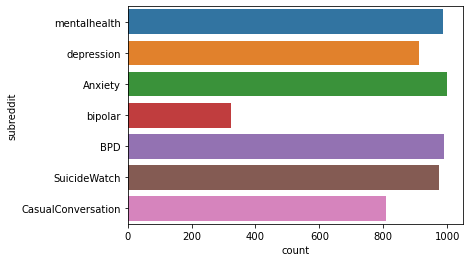

In [21]:
# Countplot by subreddit, after dropping data points.

sns.countplot(y="subreddit", data=df)

In [22]:
# Almost 6000 documents after the cleaning

df.shape

(5995, 7)

## 2.3 Preprocessing

In [23]:
# Concatenate title and body of the post in a unique feature: full_text

df['full_text'] = df['title'] + " " + df['body']

### 2.3.1 Reddit-specifc preprocessing

Reddit's API return raw text which includes Reddit-specific markdown formatting, which has to be removed for the purpose of our analysis.

In [24]:
def reddit_specific_preprocessing(text):
    
    # Remove newlines (one or more)
    text = re.sub(r'\n+', ' ', text)

    # Remove quotes
    text = re.sub(r'\"?\\?&?gt;?', '', text)

    # Remove asterisk
    text = re.sub(r'\*', '', text)

    # Remove bullet points
    text = re.sub('&amp;#x200B;', '', text)

    # Remove links (always enclosed between parenthesis)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)

    # Remove strikethroughs
    text = re.sub('~', '', text)

    # Remove spoilers, which is used with < less-than (Preserves the text)
    text = re.sub('&lt;', '', text)
    text = re.sub(r'!(.*?)!', r'\1', text)

    # Code, inline and block
    text = re.sub('`', '', text)

    # Superscript (Preserves the text)
    text = re.sub(r'\^\((.*?)\)', r'\1', text)

    # Table
    text = re.sub(r'\|', ' ', text)
    text = re.sub(':-', '', text)

    # Heading
    text = re.sub('#', '', text)

    # Clean white spaces
    text = text.strip()
    text = re.sub(r'\s\s+', ' ', text)

    return text

In [25]:
# New dataframe to show the different preprocessing steps.
# Let us include the url to serve as a key to later join it with the original data.

df_preprocessing = df[['url', 'full_text']].copy()

In [26]:
df_preprocessing.head()

,url,full_text
0,https://www.reddit.com/r/mentalhealth/comments...,"Craving closeness About a year ago, I got into..."
1,https://www.reddit.com/r/mentalhealth/comments...,Mental health class I think schools should hav...
2,https://www.reddit.com/r/mentalhealth/comments...,My 7yo son accidentally fell on our pet bird a...
3,https://www.reddit.com/r/mentalhealth/comments...,Who else doesn’t want covid world to leave My ...
4,https://www.reddit.com/r/mentalhealth/comments...,my mental health is suffering due to my contro...


In [27]:
# All the preprocessing steps are sequentials
# Each new feature is named as <# step>_<preprocessing description>

df_preprocessing['01_reddit_specific'] = df_preprocessing['full_text'].apply(lambda text: reddit_specific_preprocessing(text))

In [28]:
df_preprocessing['01_reddit_specific'][0]

'Craving closeness About a year ago, I got into a relationship that lasted until December 2020. I was the one that broke up. I loved her, but I didn’t see a satisfying future for me, so it was a tough decision to make. The problem is that I now really crave the closeness I had with her, cause I don’t really get that with anyone else. I want the love we had for each other with someone else, and it’s really annoying. I want the spooning, the sex, everything. I’m only 18, so it’s probably not something I should be thinking about, but I do. Is this normal, or should I seek help?'

### 2.3.2 General purpose preprocessing

#### Remove stopwords

In [29]:
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df_preprocessing['02_remove_stopwords'] = df_preprocessing['01_reddit_specific'].apply(lambda text: remove_stopwords(text))

In [30]:
df_preprocessing['02_remove_stopwords'][0]

'Craving closeness About year ago, I got relationship lasted December 2020. I one broke up. I loved her, I didn’t see satisfying future me, tough decision make. The problem I really crave closeness I her, cause I don’t really get anyone else. I want love someone else, it’s really annoying. I want spooning, sex, everything. I’m 18, it’s probably something I thinking about, I do. Is normal, I seek help?'

#### Remove punctuation

In [31]:
import string

PUNCTUATION = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCTUATION))

df_preprocessing['03_remove_punctuation'] = df_preprocessing['02_remove_stopwords'].apply(lambda text: remove_punctuation(text))

In [32]:
df_preprocessing['03_remove_punctuation'][0]

'Craving closeness About year ago I got relationship lasted December 2020 I one broke up I loved her I didn’t see satisfying future me tough decision make The problem I really crave closeness I her cause I don’t really get anyone else I want love someone else it’s really annoying I want spooning sex everything I’m 18 it’s probably something I thinking about I do Is normal I seek help'

#### Lemmatization

In [33]:
import spacy
nlp = spacy.load('en_core_web_sm')

/opt/anaconda3/lib/python3.8/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [34]:
def lemmatize(text, pos_list=None):
    
    if pos_list is None:
        return [token.lemma_ for token in nlp(text)]
    
    else:
        return [token.lemma_ for token in nlp(text) if token.pos_ in pos_list]

In [148]:
# Standard lemmatization

df_preprocessing['lemmatization_standard'] = df_preprocessing['03_remove_punctuation'].apply(lambda text: lemmatize(text))
df_preprocessing['lemmatization_standard'] = df_preprocessing['lemmatization_standard'].apply(lambda tokens: ' '.join(tokens))

In [149]:
df_preprocessing['lemmatization_standard'][0]

'crave closeness about year ago -PRON- get relationship last December 2020 -PRON- one break up -PRON- love -PRON- -PRON- do not see satisfy future -PRON- tough decision make the problem -PRON- really crave closeness -PRON- -PRON- cause -PRON- do not really get anyone else -PRON- want love someone else -PRON- ’ really annoying -PRON- want spoon sex everything -PRON- be 18 -PRON- ’ probably something -PRON- think about -PRON- do be normal -PRON- seek help'

In [35]:
# Lemmatization keeping only Nouns and Adjectives

pos_list = ['NOUN', 'ADJ']
df_preprocessing['lemmatization_nuon_adj'] = df_preprocessing['03_remove_punctuation'].apply(lambda text: lemmatize(text, pos_list=pos_list))
df_preprocessing['lemmatization_nuon_adj'] = df_preprocessing['lemmatization_nuon_adj'].apply(lambda tokens: ' '.join(tokens))

In [36]:
# Comparing the two types of lemmatizations, the one keeping only Nuons and Adjectives seems better.
# Even though it is more aggressive, meaning that we lose more content, it reduces the variability drastically,
# yet still conveying the important information.

df_preprocessing['lemmatization_nuon_adj'][0]

'closeness year relationship one future tough decision problem closeness annoying sex normal help'

In [152]:
# Save dataset

df_preprocessing.to_csv('data_preprocessed.csv')

In [4]:
# Upload dataset

#df_preprocessing = pd.read_csv('data_preprocessed.csv')

## 2.4 Pre-Post processing analysis

In [37]:
df_preprocessing = df_preprocessing.merge(df[['url', 'subreddit']], on='url')

In [154]:
subreddits = list(set(df['subreddit']))
subreddits

['BPD',
 'bipolar',
 'SuicideWatch',
 'CasualConversation',
 'Anxiety',
 'depression',
 'mentalhealth']

### Number chars

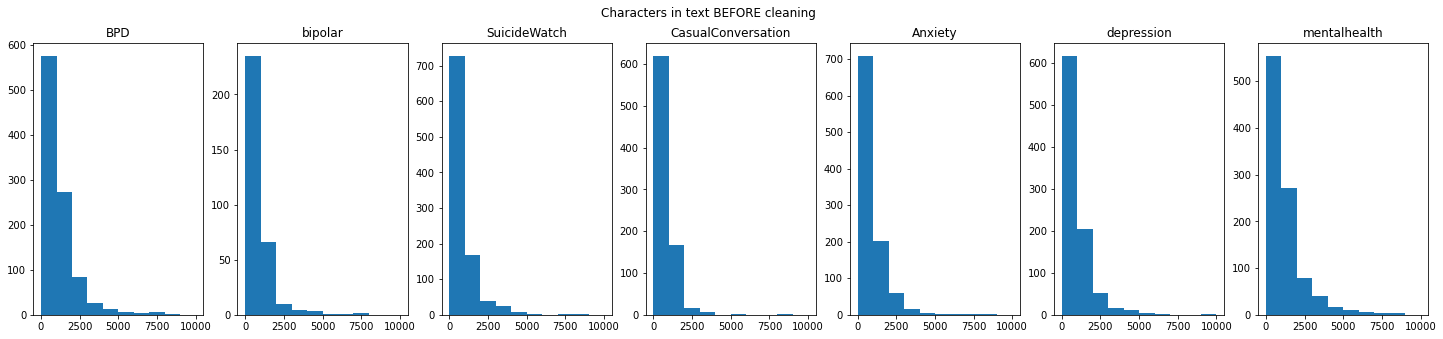

In [162]:
# Numbers characters in text BEFORE cleaning

fig, ax= plt.subplots(1, len(subreddits) ,figsize=(25,5))

for i, sub in enumerate(subreddits):
    
    text_len = df_preprocessing[df_preprocessing['subreddit']==sub]['full_text'].str.len()
    ax[i].hist(text_len, range=(0, 10000))
    ax[i].set_title(sub)
    
fig.suptitle('Characters in text BEFORE cleaning')
plt.show()

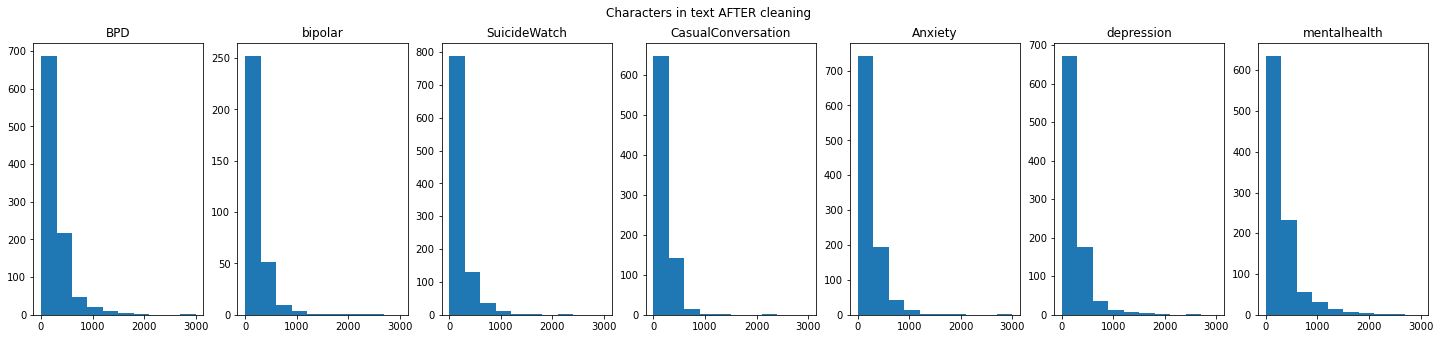

In [161]:
# Numbers characters in text AFTER cleaning

fig, ax= plt.subplots(1, len(subreddits) ,figsize=(25,5))

for i, sub in enumerate(subreddits):
    
    text_len = df_preprocessing[df_preprocessing['subreddit']==sub]['lemmatization_nuon_adj'].str.len()
    ax[i].hist(text_len, range=(0, 3000))
    ax[i].set_title(sub)
    
fig.suptitle('Characters in text AFTER cleaning')
plt.show()

### Number words

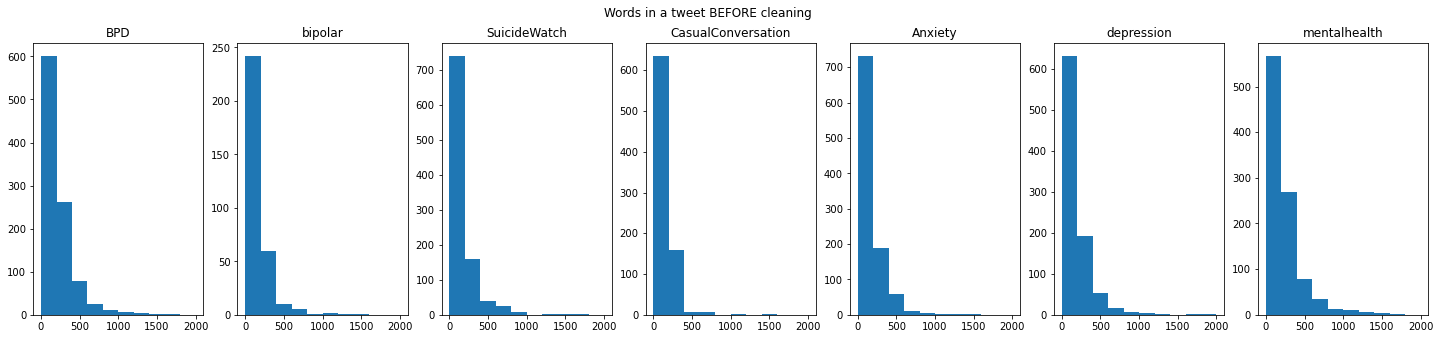

In [164]:
# Numbers words in text BEFORE cleaning

fig, ax= plt.subplots(1, len(subreddits) ,figsize=(25,5))

for i, sub in enumerate(subreddits):
    
    text_len = df_preprocessing[df_preprocessing['subreddit']==sub]['full_text'].str.split().map(lambda x: len(x))
    ax[i].hist(text_len, range=(0, 2000))
    ax[i].set_title(sub)
    
fig.suptitle('Words in a tweet BEFORE cleaning')
plt.show()

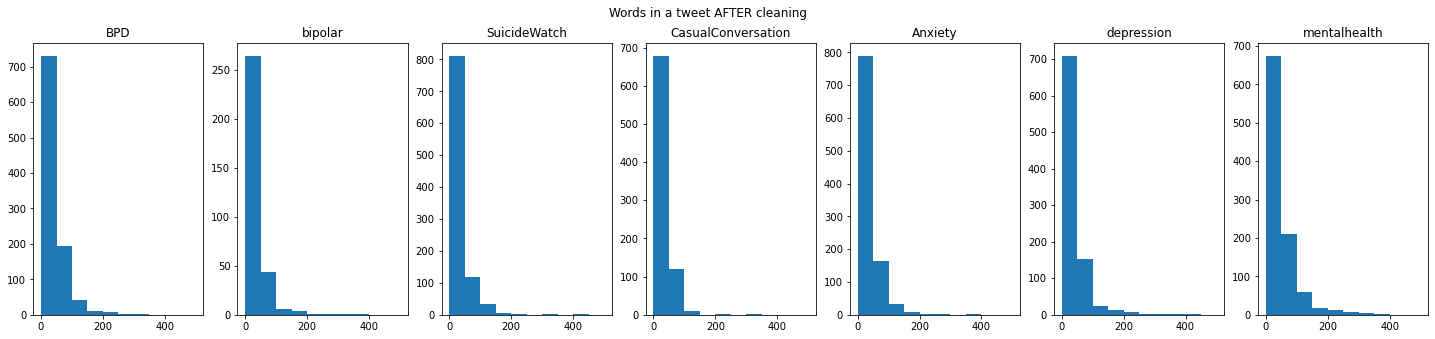

In [165]:
# Numbers words in text BEFORE cleaning

fig, ax= plt.subplots(1, len(subreddits) ,figsize=(25,5))

for i, sub in enumerate(subreddits):
    
    text_len = df_preprocessing[df_preprocessing['subreddit']==sub]['lemmatization_nuon_adj'].str.split().map(lambda x: len(x))
    ax[i].hist(text_len, range=(0, 500))
    ax[i].set_title(sub)
    
fig.suptitle('Words in a tweet AFTER cleaning')
plt.show()

# 3. Analysis (10 pts)

*Use at least **five** of the following analysis methods to the data set (justify your choices and make them explicit):*

* Word embeddings 
* Document embeddings
* TFIDF analysis
* Topic models
* Dimensionality reduction
* Clustering
* Language models

*Justify your choice of the number of latent dimensions/topics/clusters!*
*Your analysis needs to be run on **at least 5,000** preprocessed documents!*

*If appropriate for your problem, feel free to explore other methods we discussed (NER, parsing, POS, etc.), or algorithms not covered in class (e.g., clustering algorithms, etc.), as long as they do not require additional libraries (**up to 2 bonus points**).*

## 3.1 Language models

### BOW 

In [209]:
from sklearn.feature_extraction.text import CountVectorizer

In [210]:
def bow_most_common(data, ngram):
    
    bow = CountVectorizer(analyzer='word', 
                      ngram_range=(ngram, ngram), 
                      min_df=0.001, 
                      max_df=0.75, 
                      stop_words='english') 
    
    X = bow.fit_transform(data)
    return Counter(dict(zip(bow.get_feature_names(), X.sum(axis=0).A1))).most_common(10)

#### Original text

In [211]:
# Most common unigram original text
# Not very informative...

bow_most_common(data=df_preprocessing['full_text'], ngram=1)

[('just', 9132),
 ('like', 7843),
 ('feel', 6154),
 ('don', 6023),
 ('know', 4719),
 ('ve', 4407),
 ('want', 4089),
 ('time', 3549),
 ('really', 3491),
 ('life', 3410)]

In [212]:
# Most common bigram original text

bow_most_common(data=df_preprocessing['full_text'], ngram=2)

[('feel like', 2246),
 ('don know', 1643),
 ('don want', 944),
 ('just want', 622),
 ('mental health', 546),
 ('feels like', 425),
 ('just don', 333),
 ('don think', 324),
 ('just feel', 304),
 ('felt like', 295)]

In [213]:
# Most common trigram original text

bow_most_common(data=df_preprocessing['full_text'], ngram=3)

[('just feel like', 116),
 ('just don know', 105),
 ('don feel like', 91),
 ('don know anymore', 66),
 ('mental health issues', 66),
 ('feel like ve', 65),
 ('feel like just', 59),
 ('just don want', 53),
 ('don know just', 52),
 ('makes feel like', 52)]

#### Preprocessed text

In [214]:
# Most common unigram on preprocessed text
# Already much better information

bow_most_common(data=df_preprocessing['lemmatization_nuon_adj'], ngram=1)

[('time', 4229),
 ('thing', 3427),
 ('life', 3386),
 ('people', 3304),
 ('day', 2996),
 ('year', 2738),
 ('friend', 2580),
 ('bad', 2329),
 ('good', 2161),
 ('anxiety', 1983)]

In [215]:
# Most common bigram on preprocessed text

bow_most_common(data=df_preprocessing['lemmatization_nuon_adj'], ngram=2)

[('mental health', 501),
 ('year old', 312),
 ('panic attack', 291),
 ('good friend', 280),
 ('long time', 208),
 ('high school', 161),
 ('day day', 130),
 ('suicidal thought', 126),
 ('time time', 126),
 ('hard time', 117)]

In [216]:
# Most common trigram on preprocessed text

bow_most_common(data=df_preprocessing['lemmatization_nuon_adj'], ngram=3)

[('mental health issue', 66),
 ('long story short', 38),
 ('anxiety panic attack', 20),
 ('mental health problem', 19),
 ('life year old', 17),
 ('bad panic attack', 15),
 ('mental health bad', 15),
 ('people mental health', 15),
 ('bad mental health', 14),
 ('friend good friend', 14)]

#### Specific subreddit: SuicideWatch

In [217]:
# Original text

data_suicide_watch = df_preprocessing[df_preprocessing['subreddit']=='SuicideWatch']['full_text']

In [218]:
bow_most_common(data=data_suicide_watch, ngram=1)

[('just', 1442),
 ('don', 1087),
 ('like', 965),
 ('want', 919),
 ('life', 820),
 ('feel', 767),
 ('know', 641),
 ('ve', 605),
 ('people', 546),
 ('think', 425)]

In [219]:
bow_most_common(data=data_suicide_watch, ngram=2)

[('feel like', 291),
 ('don want', 243),
 ('don know', 240),
 ('just want', 151),
 ('want die', 104),
 ('don think', 83),
 ('just don', 74),
 ('feels like', 61),
 ('suicidal thoughts', 55),
 ('ve tried', 41)]

In [220]:
bow_most_common(data=data_suicide_watch, ngram=3)

[('just don want', 20),
 ('just want die', 20),
 ('don want live', 19),
 ('just feel like', 16),
 ('don want die', 15),
 ('just don know', 15),
 ('feel like ve', 12),
 ('want die don', 12),
 ('makes feel like', 11),
 ('don feel like', 10)]

In [221]:
# Preprocessed text

data_suicide_watch = df_preprocessing[df_preprocessing['subreddit']=='SuicideWatch']['lemmatization_nuon_adj']

In [222]:
bow_most_common(data=data_suicide_watch, ngram=1)

[('life', 814),
 ('people', 544),
 ('time', 493),
 ('year', 432),
 ('thing', 430),
 ('friend', 375),
 ('day', 371),
 ('bad', 322),
 ('good', 299),
 ('suicide', 254)]

In [223]:
bow_most_common(data=data_suicide_watch, ngram=2)

[('year old', 49),
 ('suicidal thought', 48),
 ('good friend', 33),
 ('mental health', 33),
 ('friend family', 31),
 ('long time', 26),
 ('high school', 24),
 ('life bad', 23),
 ('people life', 22),
 ('day day', 21)]

In [224]:
bow_most_common(data=data_suicide_watch, ngram=3)

[('long story short', 6),
 ('depression suicidal thought', 4),
 ('fuck fuck fuck', 4),
 ('good friend year', 4),
 ('mental health issue', 4),
 ('tired tired tired', 4),
 ('year good friend', 4),
 ('18th birthday dad', 3),
 ('able smelly piece', 3),
 ('age soo hornnny', 3)]

### TF-IDF

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [226]:
def tfidf_score(data, result=False):
    tfidf = TfidfVectorizer(analyzer='word', 
                            min_df=0.001, 
                            max_df=0.75, 
                            stop_words='english', 
                            sublinear_tf=True)

    X_tfidf = tfidf.fit_transform(data)

    bow = CountVectorizer(analyzer='word', 
                          min_df=0.001, 
                          max_df=0.75, 
                          stop_words='english')

    X_bow = bow.fit_transform(data)

    words = pd.DataFrame(data={'word': bow.get_feature_names(), 
                               'tf': X_bow.sum(axis=0).A1, 
                               'idf': tfidf.idf_,
                               'tfidf': X_tfidf.sum(axis=0).A1}).sort_values(['tfidf', 'tf', 'idf'], ascending=False).reset_index().drop('index', axis=1)

    
    if result:
        return words
    
    print('Words with highest TF-IDF score')
    print()
    print(words.head(10))
    print()
    print('Words with lowest TF-IDF score')
    print()
    print(words.tail(10))

In [227]:
# Original text, all subreddits

tfidf_score(data=df_preprocessing['full_text'])

Words with highest TF-IDF score

     word    tf       idf       tfidf
0    just  9132  1.496365  248.309559
1    like  7843  1.589322  225.186726
2    feel  6154  1.765409  210.771047
3     don  6023  1.784961  202.747297
4    want  4089  2.011309  175.408830
5    know  4719  1.872405  172.972850
6      ve  4407  1.995389  165.345236
7    life  3410  2.180241  150.583065
8  really  3491  2.144513  145.266222
9  people  3316  2.227485  141.590639

Words with lowest TF-IDF score

               word  tf       idf     tfidf
5609      summarize   6  7.752938  0.621865
5610       gorgeous   6  7.752938  0.616453
5611  consideration   6  7.752938  0.609517
5612    unknowingly   6  7.752938  0.607130
5613    transparent   6  7.752938  0.575454
5614     pedophilia   6  7.752938  0.554672
5615        remarks   6  7.752938  0.541486
5616    socialising   6  7.752938  0.534423
5617        disdain   6  7.752938  0.521466
5618         tables   6  7.752938  0.520355


In [228]:
# Preprocessed text, all subreddits

tfidf_score(data=df_preprocessing['lemmatization_nuon_adj'])

Words with highest TF-IDF score

      word    tf       idf       tfidf
0     time  4229  1.952980  228.458071
1     life  3386  2.176448  221.297238
2   people  3304  2.227485  209.230315
3    thing  3427  2.156634  199.371142
4      day  2996  2.236059  192.455339
5   friend  2580  2.474094  176.573912
6      bad  2329  2.397700  174.796002
7     year  2738  2.293960  173.860933
8  anxiety  1983  2.702166  166.890277
9     good  2161  2.434118  159.560178

Words with lowest TF-IDF score

               word  tf       idf     tfidf
2831         signal   6  7.752938  0.936843
2832        measure   6  7.752938  0.932184
2833  consideration   6  7.752938  0.916568
2834        skilled   6  7.752938  0.912244
2835       gorgeous   6  7.752938  0.889966
2836       contrary   6  7.752938  0.878905
2837         remark   6  7.752938  0.872765
2838       handling   6  7.752938  0.853735
2839    transparent   6  7.752938  0.853316
2840          niche   6  7.752938  0.831069


In [229]:
# Preprocessed text, divided by subreddit

for subreddit in list(set(df_preprocessing['subreddit'])):
    print('*** ', subreddit, ' ***')
    print()
    tfidf_score(data=df_preprocessing[df_preprocessing['subreddit']==subreddit]['lemmatization_nuon_adj'])
    print()

***  BPD  ***

Words with highest TF-IDF score

           word   tf       idf      tfidf
0          time  871  1.770673  39.835182
1        people  719  1.988926  38.041987
2         thing  780  1.886008  36.976020
3          life  501  2.212748  30.530914
4        friend  488  2.390335  30.413698
5  relationship  480  2.410785  29.419380
6           day  494  2.216143  28.370808
7           bad  415  2.316227  27.711002
8          good  406  2.261368  27.015537
9          year  432  2.312474  26.494109

Words with lowest TF-IDF score

              word  tf       idf     tfidf
4824  reevaluation   1  7.206576  0.055229
4825   retaliation   1  7.206576  0.055229
4826        screed   1  7.206576  0.055229
4827      solidify   1  7.206576  0.055229
4828        specie   1  7.206576  0.055229
4829       ugliest   1  7.206576  0.055229
4830       unequal   1  7.206576  0.055229
4831    unwavering   1  7.206576  0.055229
4832         whine   1  7.206576  0.055229
4833         wound   1  7.2

### What's wrong?

The TF-IDF above is not very useful because it highlights important words to distinguish between documents within the same subreddit, not between different subreddits! <br>
As you can see from the results, the words with highest score are meaningful words like life, people, time and friend. These words are definetely important, but not for our purpose. In fact, for every subreddit, the words with the highest score are always the same or almost so. <br>

### How do we fix this?

A solution is to aggregate all the documents belonging to the same subreddit in one single document and repeat the procedure above. In this way, the TF-IDF will give a bigger weight to common words within a subreddit which are uncommon in other subreddits.

In [230]:
# MUCH BETTER!

document_list = []

for subreddit in list(set(df_preprocessing['subreddit'])):
    document_list.append(' '.join(df_preprocessing[df_preprocessing['subreddit']==subreddit]['lemmatization_nuon_adj']))
    
tfidf_score(data=document_list)

Words with highest TF-IDF score

         word   tf       idf     tfidf
0       manic  147  1.287682  0.215881
1   worthless   98  1.287682  0.185689
2      burden   85  1.287682  0.177688
3   inpatient   32  1.287682  0.157416
4         mum   50  1.287682  0.154827
5        ward   34  1.287682  0.154476
6    headache   48  1.287682  0.152000
7  meaningful   45  1.287682  0.150763
8   psychosis   32  1.470004  0.148625
9    delusion   26  1.470004  0.147767

Words with lowest TF-IDF score

             word  tf       idf     tfidf
10512    workpart   1  2.386294  0.015792
10513     wrecker   1  2.386294  0.015792
10514    wresting   1  2.386294  0.015792
10515  wrongdoing   1  2.386294  0.015792
10516         yea   1  2.386294  0.015792
10517    youngbut   1  2.386294  0.015792
10518        youu   1  2.386294  0.015792
10519     yoyoing   1  2.386294  0.015792
10520        zero   1  2.386294  0.015792
10521     zipping   1  2.386294  0.015792


In [231]:
# What if we only consider the subreddits regarding specific illnesses?

document_list = []

for subreddit in list(set(df_preprocessing['subreddit'])):
    
    if subreddit in ['CasualConversation', 'mentalhealth']:
        pass
    
    document_list.append(' '.join(df_preprocessing[df_preprocessing['subreddit']==subreddit]['lemmatization_nuon_adj']))
    
tfidf_score(data=document_list)

Words with highest TF-IDF score

         word   tf       idf     tfidf
0       manic  147  1.287682  0.215881
1   worthless   98  1.287682  0.185689
2      burden   85  1.287682  0.177688
3   inpatient   32  1.287682  0.157416
4         mum   50  1.287682  0.154827
5        ward   34  1.287682  0.154476
6    headache   48  1.287682  0.152000
7  meaningful   45  1.287682  0.150763
8   psychosis   32  1.470004  0.148625
9    delusion   26  1.470004  0.147767

Words with lowest TF-IDF score

             word  tf       idf     tfidf
10512    workpart   1  2.386294  0.015792
10513     wrecker   1  2.386294  0.015792
10514    wresting   1  2.386294  0.015792
10515  wrongdoing   1  2.386294  0.015792
10516         yea   1  2.386294  0.015792
10517    youngbut   1  2.386294  0.015792
10518        youu   1  2.386294  0.015792
10519     yoyoing   1  2.386294  0.015792
10520        zero   1  2.386294  0.015792
10521     zipping   1  2.386294  0.015792


Not much different from before, probably because r/CasualConversation and r/mentalhealth contain general discussions and are unlikely to have words with high TF-IDF.

## 3.2 Word Embeddings + Dimensionality Reduction

In this section we will use Word Embeddings to vectorize full sentences and plot them in a 2-dimensional space, after proper dimensionality reduction. <br>

The goal is to explore how different embedding approaches provide good ways to separate the labels, as shown in the plots.

In [76]:
# Word2Vec trained on the corpus

from gensim.models import Word2Vec

corpus = df_preprocessing['lemmatization_nuon_adj'].apply(lambda x: x.split()).tolist()

w2v_model = Word2Vec(size=100, 
                     window=15, 
                     sample=0.0001, 
                     iter=200, 
                     negative=5, 
                     min_count=100, 
                     workers=-1, 
                     hs=0)

w2v_model.build_vocab(corpus)

w2v_model.train(corpus, 
                total_examples=w2v_model.corpus_count, 
                epochs=w2v_model.epochs)

(0, 0)

In [77]:
# Compute most similar words, exploitying semantic relationships learned from the corpus.

print(w2v_model.wv.most_similar('suicide', topn=10))

[('big', 0.29244956374168396), ('support', 0.2772206664085388), ('busy', 0.26326894760131836), ('abuse', 0.26100456714630127), ('person', 0.24186566472053528), ('money', 0.23626305162906647), ('late', 0.20484235882759094), ('video', 0.20483127236366272), ('online', 0.1984146237373352), ('deal', 0.19650354981422424)]


In [78]:
# Print the cosine similarity between 2 words.

print(w2v_model.wv.similarity('depression', 'anxiety'))

0.1058805


Above I have trained a Word2Vec on the corpus made up of the different posts in order to develop an embedding which takes into account the semantic relationship between the different words. <br>

For the purposes of the analysis, it is more useful to import a pretrained model (i.e. a model already trained on a more large and comprehensive corpus of documents) and use it to analyze our data. 

In [9]:
# Upload pre-trained model
# download @ https://www.kaggle.com/leadbest/googlenewsvectorsnegative300

import gensim.models.keyedvectors as word2vec

pretrained_model = word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [68]:
# The pretrained model gives a higher degree of similarity between the words 'depression' and 'anxiety'

pretrained_model.similarity('depression', 'anxiety')

0.51021266

In order to use the pretrained model on whole sentences instead of just words,a simple solution is to average the vectors of the words of the sentences in a single vector. <br>

The drawback of this approach is that, if a post is very long and cover different types of information, by averaging all the embeddings we lose information. <br>

If we want to improve the analysis, a solution might be to split long posts into different ones when the main topic changes. This has not been done in this analysis.

In [69]:
# In order to use the pretrained model on whole sentences instead of just words,
# a simple solution is to average the vectors of the words of the sentences in a single vector.

def vectorize(df, model):
    
    list_of_docs = df.apply(lambda x: x.split()).to_list()

    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
            
    return np.array(features)
    
vectorized_docs = vectorize(df_preprocessing['lemmatization_nuon_adj'], model=pretrained_model)

In [205]:
import matplotlib.pyplot as plt
import seaborn as sb

sb.set_context('notebook')

def plot_vectors(vectors, title, labels=None):

    fig = plt.figure(figsize=(10,10))

    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})

    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

        
    # Random colors for better visualization
    n_labels = len(df.label.unique())
    label_colors = []
    for l in range(n_labels):
        label_colors.append(list(np.random.rand(4,)))
    
    cMap = colors.ListedColormap(label_colors)
      
    ax = fig.add_subplot(111)
    frame1 = plt.gca() 
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])

    for l, label in enumerate(df.label.unique()):
        df2 = df[df.label == label]
        color_values = [label_colors[l]] * len(df2)
        ax.scatter(df2['x'], df2['y'], 
                   c=color_values, 
                   cmap=cMap, 
                   edgecolor='black', 
                   label=label, 
                   alpha=0.4, 
                   s=100)

    plt.title(title)
    plt.legend()
    plt.show()

In [206]:
from sklearn.decomposition import TruncatedSVD

def reduce_and_plot(df, labels, title, sample=False, model=pretrained_model):
    
    docs = vectorize(df, model)
    
    svd = TruncatedSVD(n_components=2)
    docs_reduced = svd.fit_transform(docs)
    
    stack = np.hstack((docs_reduced, labels.to_numpy().reshape(-1,1)))
    
    if sample:
        stack = stack[np.random.randint(stack.shape[0], size=300), :]
    
    plot_vectors(stack[:, [0,1]], labels=stack[:, 2], title=title)

### BINARY LABELLING: normal vs. mental health related post

In [40]:
def binary_label(text):
    if text == 'CasualConversation':
        return 0
    return 1

binary_labels = df_preprocessing.subreddit.apply(lambda x: binary_label(x))

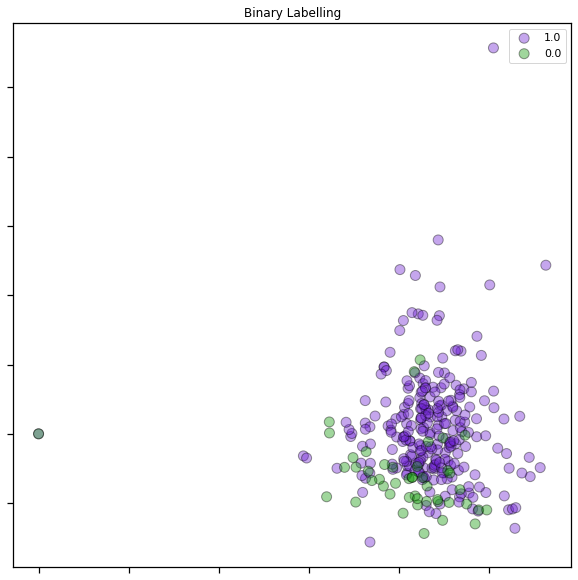

In [212]:
# Using a random sample of the data

reduce_and_plot(df=df_preprocessing['lemmatization_nuon_adj'], labels=binary_labels, title='Binary Labelling', sample=True)

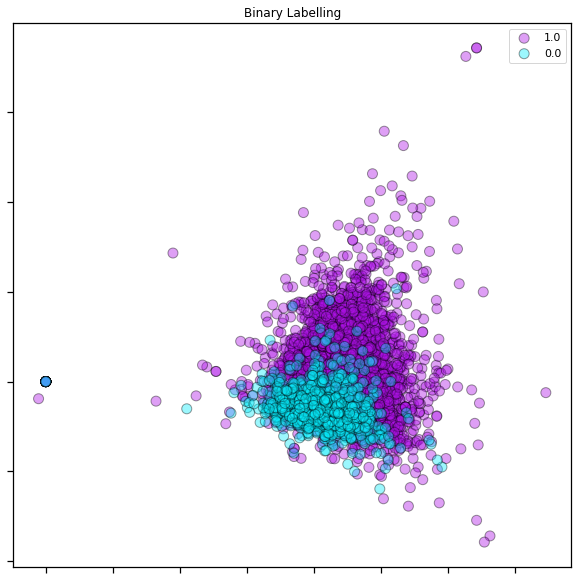

In [211]:
# Using the whole dataset

reduce_and_plot(df=df_preprocessing['lemmatization_nuon_adj'], labels=binary_labels, title='Binary Labelling')

### PROBLEM SPECIFIC: anxiety vs. depression vs. suicide

In [219]:
problem_specific = df_preprocessing[df_preprocessing['subreddit'].isin(['Anxiety', 'depression', 'SuicideWatch'])]

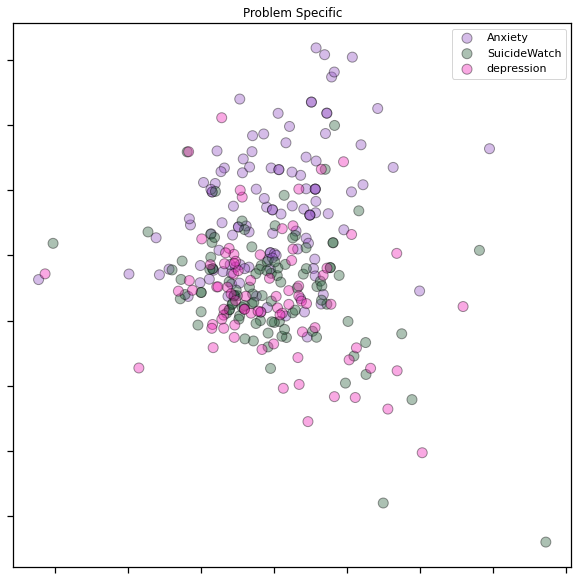

In [218]:
# Using a random sample of the data

reduce_and_plot(df=problem_specific['lemmatization_nuon_adj'], labels=problem_specific.subreddit, title='Problem Specific',sample=True)

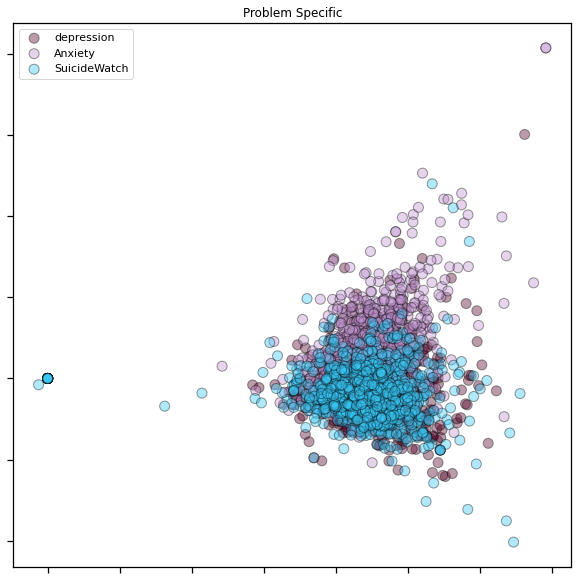

In [220]:
# Using the whole dataset

reduce_and_plot(df=problem_specific['lemmatization_nuon_adj'], labels=problem_specific.subreddit, title='Problem Specific')

It appears that the embedding representation of the sentences is successful in dividing normal vs. mental-health related posts, but has a lower efficacy in separating within different mental health conditions. <br>

In particular, the last plot is able to distinguish anxiety from the others main conditions, but overlaps depression and suicide posts. This result should be expected because most suicide posts are similar in nature to depression-related posts as most people with suicide tendencies struggle indeed with depression. Our goal should be to spot those suicide posts which are more extreme that the average depression post, indicating a worsening of the condition. <br>

This task, in order to be succesful, requires a better labelling of the data which is not available in this dataset.

## 3.3 Author Topic Modelling

In [168]:
from gensim.models import AuthorTopicModel
from gensim.test.utils import datapath, temporary_file

In [171]:
instances = df_preprocessing['lemmatization_nuon_adj'].apply(str.split).tolist()
phrases = Phrases(instances, min_count=5, threshold=1)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)
dictionary.filter_extremes(no_below=50, no_above=0.3)
print(dictionary, flush=True)

ldacorpus = [dictionary.doc2bow(text) for text in instances]
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus]

Dictionary(660 unique tokens: ['annoying', 'decision', 'future', 'help', 'normal']...)


In [172]:
from collections import defaultdict
author2doc = defaultdict(list) 

for i, subreddit in enumerate(df['subreddit']):
    author2doc[subreddit].append(i)
    
len(author2doc)

7

In [173]:
len(ldacorpus)

5995

In [174]:
coherence_values = []
author_model_list = []

dev_size = len(ldacorpus)

dev_author2doc = {key: [idx for idx in value if idx < dev_size] for key, value in author2doc.items()}

for num_topics in range(5, 11):
    author_model = AuthorTopicModel(corpus=list(ldacorpus[:dev_size]), 
                                    author2doc=dev_author2doc, 
                                    id2word=dictionary, 
                                    num_topics=num_topics,
                                    alpha=0.5,
                                    random_state=42)
    
    coherencemodel_umass = CoherenceModel(model=author_model, 
                                          texts=instances[:dev_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=author_model, 
                                       texts=instances[:dev_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

5 -1.5702481896323555 0.3900201542485096
6 -1.6530854485456814 0.3789223408467466
7 -1.6613323221838308 0.38481987983673566
8 -1.7117316597793701 0.4039105267930758
9 -1.707271034602926 0.4035037685640337
10 -1.705450646066692 0.40301357346251016


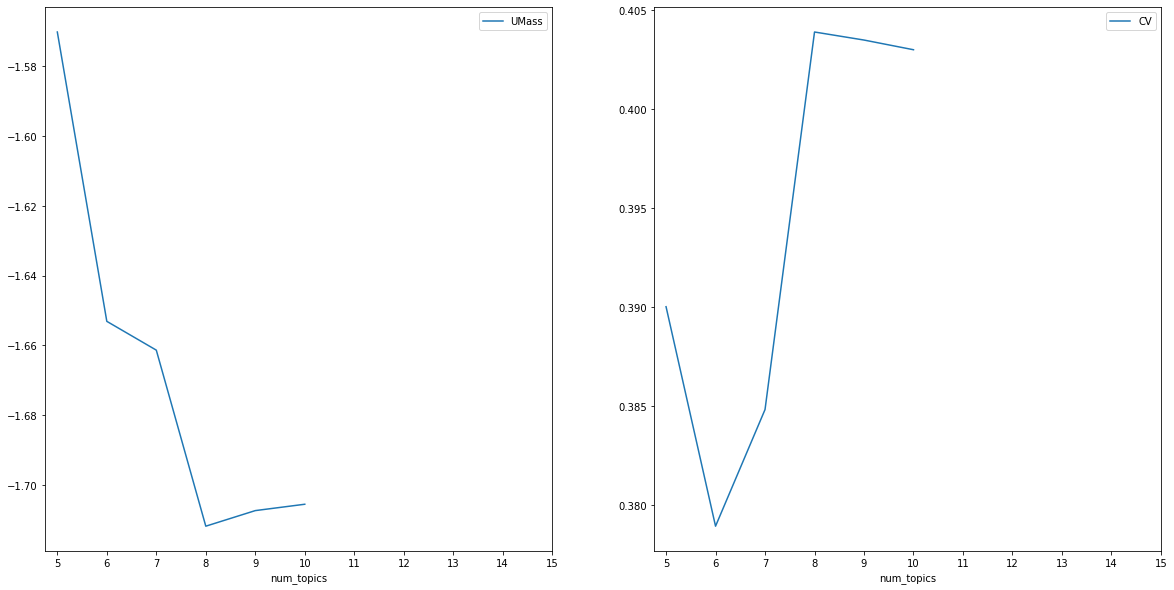

In [175]:
%matplotlib inline
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,16));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,16));

In [177]:
# Train model with best number of topics

n_topics_author = 8

num_passes = 10
chunk_size = len(model_corpus) * num_passes/200

author_model = AuthorTopicModel(corpus=list(ldacorpus), 
                                author2doc=author2doc, 
                                id2word=dictionary, 
                                num_topics=n_topics_author,
                                passes=num_passes,
                                chunksize=chunk_size,
                                alpha=0.5,
                                random_state=0)

In [191]:
import re

topic_sep = re.compile("0\.[0-9]{3}\*") 

author_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model.print_topics(num_topics=n_topics_author, num_words=10)]

author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:10]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "year", "friend", "good", "first", "funny", "school", "today", "old", "time", "kid"
2 "life", "suicide", "year", "bad", "point", "parent", "depression", "suicidal", "family", "pain"
3 "anxiety", "anxious", "attack", "panic", "bad", "day", "test", "health", "doctor", "boss"
4 "therapist", "episode", "therapy", "medication", "disorder", "week", "med", "bipolar", "mood", "month"
5 "time", "thing", "people", "day", "life", "friend", "good", "year", "much", "way"
6 "people", "text", "phone", "way", "number", "feeling", "pain", "personal", "call", "fear"
7 "heart", "brain", "physical", "side", "symptom", "experience", "mine", "clean", "man", "event"
8 "person", "bad", "thought", "lot", "post", "mind", "thing", "people", "car", "normal"


Based on the words that make up the topics, we can try to find the common denominator with some intuition after reading a lot of posts:

1. talking about the past or about a story
2. talking about depression and its causes/consequences
3. talking about anxiety and its causes/consequences
4. talking about therapy and medication: what people are doing and what is the progress
5. general conversational topics (positive-ish)
6. talking over phone/internet
7. physiscal symptoms of the disease
8. general conversational topics (negative-ish)

In [184]:
# Initialize mapping from covariate(=author/country) to topic distro, set all to 0.0

author_vecs = {author: {author_descriptors[t]: 0.0
                         for t in range(author_model.num_topics)}
              for author in author_model.id2author.values()}


for author in author_model.id2author.values():
    for (t, v) in author_model.get_author_topics(author):
        author_vecs[author][author_descriptors[t]] = v


target_countries = list(set(df['subreddit']))

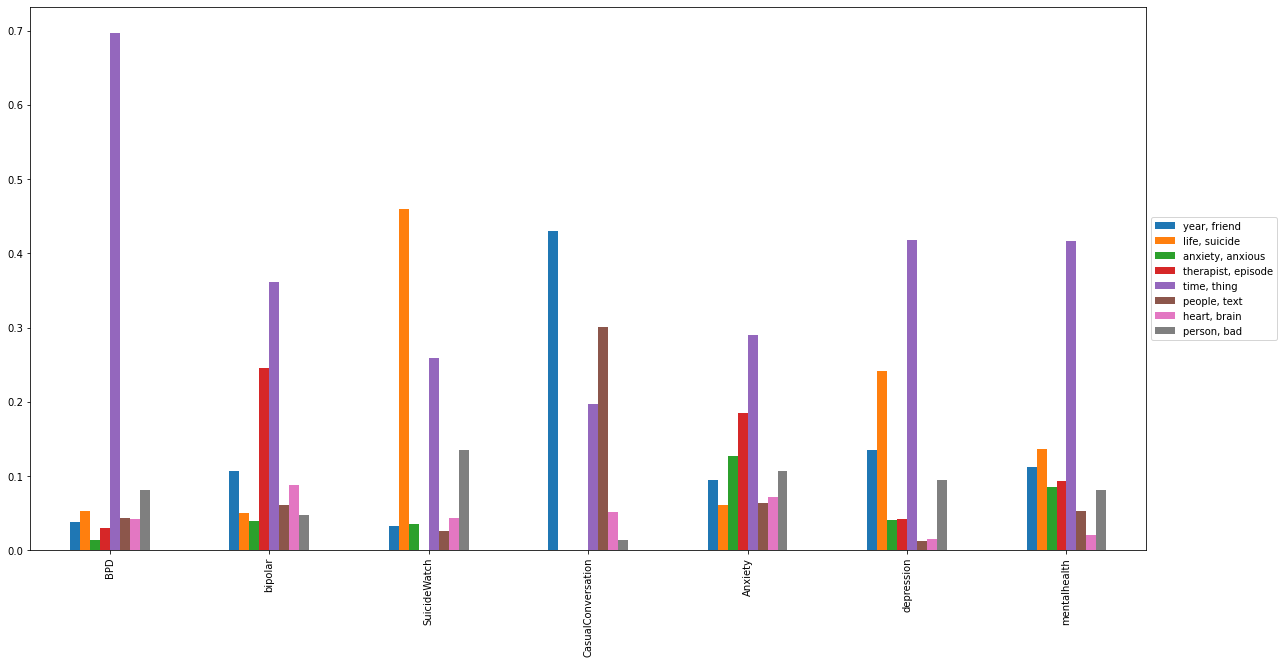

In [185]:
author_df = pd.DataFrame.from_dict(author_vecs)


fig, ax = plt.subplots(figsize=(20,10))
author_df[target_countries].T.plot.bar(ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

Compared to normal Topic Modelling, Author Topic Modelling tends to emphasize more the dominant topic in the category. This being said, we can notice that all the subreddits have a strong component of <5. general conversational topics (positive-ish)>. 

To compare the different subreddits, we can compare them with r/mentalhealth, which should have average values for each topic.

As expected the topic <4. talking about therapy and medication: what people are doing and what is the progress> is present in all subreddits in different proportions except r/CasualConversation. It is interesting that this topic is way more present for r/bipolar: bipolarism, in fact, with its up and downs, can have very bad consequences on the lives of people, which realize their instability and look for help. The same is somewhat true for r/Anxiety: people expose their problem and look for help.

What is striking is that <4. talking about therapy and medication: what people are doing and what is the progress> is completely absent in r/SuicideWatch and very low in r/depression. This highlights the nature of depression and suicidal thoughs and the hopelesness of the people affected from these conditions: very few posts are made looking for help, most are instead just rants. 

## 3.4 Sentiment Analysis

Here I use a pre-trained sentiment analysis analyzer to compare the distribution of the sentiment in the different subreddits.

In [193]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/eliogruttadauria/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [194]:
def compute_polarity_score(text):
    return sid.polarity_scores(text)['compound']

In [195]:
df_preprocessing['full_text_score'] = df_preprocessing['full_text'].apply(lambda x: compute_polarity_score(x))

In [196]:
# Average sentiment per subreddit

df_preprocessing.groupby('subreddit').mean()['full_text_score']

subreddit
Anxiety              -0.299762
BPD                  -0.164272
CasualConversation    0.463926
SuicideWatch         -0.455741
bipolar              -0.125181
depression           -0.329389
mentalhealth         -0.216113
Name: full_text_score, dtype: float64

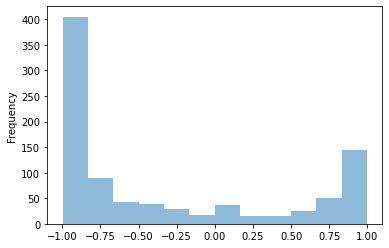

In [197]:
df_preprocessing[df_preprocessing['subreddit']=='depression']['full_text_score'].plot.hist(bins=12, alpha=0.5)

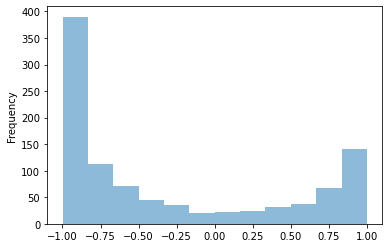

In [198]:
df_preprocessing[df_preprocessing['subreddit']=='Anxiety']['full_text_score'].plot.hist(bins=12, alpha=0.5)

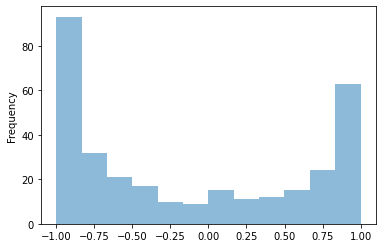

In [199]:
df_preprocessing[df_preprocessing['subreddit']=='bipolar']['full_text_score'].plot.hist(bins=12, alpha=0.5)

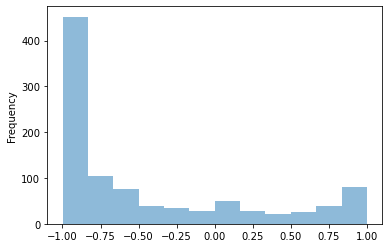

In [200]:
df_preprocessing[df_preprocessing['subreddit']=='SuicideWatch']['full_text_score'].plot.hist(bins=12, alpha=0.5)

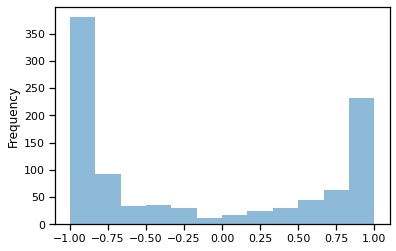

In [236]:
df_preprocessing[df_preprocessing['subreddit']=='BPD']['full_text_score'].plot.hist(bins=12, alpha=0.5)

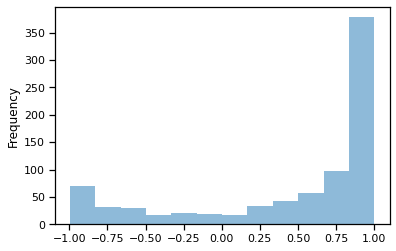

In [237]:
df_preprocessing[df_preprocessing['subreddit']=='CasualConversation']['full_text_score'].plot.hist(bins=12, alpha=0.5)

The sentiment of r/CasualConversation is definetely skewed towards the positive spectrum. <br>
Without surprise, r/SuicideWatch has the distribution most skewed toward the negative spectrum. <br>

What is interesting is that r/bipolar and r/BPD show more "even" distributions. <br>
This is in line with the specific conditions, which tend to have both highs and lows.

# 4. Prediction (12 pts)


## 4.1 Classification (7 pts)
Build a predictive model of the target label and use appropriate performance metrics. Your predictive analysis needs to involve **all** of the following, summarized in a table:

1. a most-frequent-label baseline (1 point)
2. a `LogisticRegression()` baseline with default parameters and 2-6 gram character TFIDF features (1 pts)
3. the performance of **at least** one more predictive model architecture (2 pts), including description/justification of the optmization steps taken (2 pts).
4. two bootstrap sampling significance tests of the performance difference between your best model and each of the two baselines (1 pts)

NB: Do make sure that the optimization steps are done on the development split and do *not* include the test split! Training on the test set will be graded 0!

In [38]:
from sklearn.model_selection import train_test_split

## Case 1: Binary classification: healthy vs. non healthy

In [43]:
def binary_label(text):
    if text == 'CasualConversation':
        return 0
    return 1

binary_labels = df_preprocessing.subreddit.apply(lambda x: binary_label(x))

In [44]:
X = df_preprocessing.lemmatization_nuon_adj
y = df_preprocessing.subreddit.apply(lambda x: binary_label(x))

# Split train and test
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X, y, test_size=0.4, random_state=0)

# Split test into dev and test
X_dev_binary, X_test_binary, y_dev_binary, y_test_binary = train_test_split(X_test_binary, y_test_binary, test_size=0.5, random_state=0)

### Most-frequent-label Classifier

In [45]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

In [102]:
def most_frequent_classifier(X_train, X_dev, y_train, y_dev, preds=False):
    
    most_frequent = DummyClassifier(strategy='most_frequent')
    most_frequent.fit(X_train, y_train)
    
    dumb_predictions = most_frequent.predict(X_dev)

    print(classification_report(y_dev, dumb_predictions))
    
    if preds:
        return dumb_predictions

In [107]:
most_frequent_classifier(X_train_binary, X_dev_binary, y_train_binary, y_dev_binary)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       157
           1       0.87      1.00      0.93      1042

    accuracy                           0.87      1199
   macro avg       0.43      0.50      0.46      1199
weighted avg       0.76      0.87      0.81      1199



### The Hulk with TF-IDF at post-level

In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
def hulk_vectorization_post(X_train, X_dev, X_test):
    
    vectorizer = TfidfVectorizer(ngram_range=(2,6), 
                                 min_df=0.001, 
                                 max_df=0.7, 
                                 analyzer='char',
                                 sublinear_tf=True)

    X_train = vectorizer.fit_transform(X_train)
    X_dev = vectorizer.transform(X_dev)
    X_test = vectorizer.transform(X_test)
    
    return X_train, X_dev, X_test

In [123]:
def hulk(X_train, X_dev, y_train, y_dev, model=None, preds=False):
        
    
    if model is None:
        classifier = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs')
    else:
        classifier = model
    
    classifier.fit(X_train, y_train)
    
    predictions = classifier.predict(X_dev)
    print(classification_report(y_dev, predictions))
    
    if preds:
        return predictions

In [79]:
X_train_binary_post, X_dev_binary_post, X_test_binary_post = hulk_vectorization_post(X_train_binary, X_dev_binary, X_test_binary)

In [80]:
hulk(X_train_binary_post, X_dev_binary_post, y_train_binary, y_dev_binary, model=None)

              precision    recall  f1-score   support

           0       1.00      0.01      0.03       157
           1       0.87      1.00      0.93      1042

    accuracy                           0.87      1199
   macro avg       0.94      0.51      0.48      1199
weighted avg       0.89      0.87      0.81      1199



### The Hulk with TF-IDF at document-level

In [81]:
def hulk_vectorization_docs(X_train, y_train, X_dev, X_test):
    
    join_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
    
    document_list = []

    for subreddit in list(set(join_train['subreddit'])):
        document_list.append(' '.join(join_train[join_train['subreddit']==subreddit]['lemmatization_nuon_adj']))
        
    vectorizer = TfidfVectorizer(ngram_range=(2,6), 
                             min_df=0.001, 
                             max_df=0.7, 
                             analyzer='char',
                             sublinear_tf=True)

    vectorizer.fit(document_list) 
    
    X_train_doc = vectorizer.transform(X_train)
    X_dev_doc = vectorizer.transform(X_dev)
    X_test_doc = vectorizer.transform(X_test)
    
    return X_train_doc, X_dev_doc, X_test_doc

In [82]:
X_train_binary_docs, X_dev_binary_docs, X_test_binary_docs = hulk_vectorization_docs(X_train_binary, y_train_binary, X_dev_binary, X_test_binary)

In [83]:
hulk(X_train_binary_docs, X_dev_binary_docs, y_train_binary, y_dev_binary, model=None)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       157
           1       0.87      1.00      0.93      1042

    accuracy                           0.87      1199
   macro avg       0.43      0.50      0.46      1199
weighted avg       0.76      0.87      0.81      1199



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Case 2: reduced labels

I will focus more on this case as this is the focus of my research question: to distinguish between different mental health considitons.

In particular, after the analysis conducted up to this point, I have decided to join together r/depression and r/SuicideWatch under the common label depression.

The classification task is therefore between 3 labels: anxiety, depression and normal.

In [84]:
df_reduced = df_preprocessing[df_preprocessing['subreddit'].isin(['depression', 'Anxiety', 'CasualConversation', 'SuicideWatch'])]

In [85]:
df_reduced.shape

(3695, 7)

In [86]:
def generalised_depression_label(x):
    if x == 'SuicideWatch':
        return 'depression'
    return x

In [87]:
X = df_reduced.lemmatization_nuon_adj
y = df_reduced.subreddit.apply(lambda x: generalised_depression_label(x))

# Split train and test
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X, y, test_size=0.4, random_state=0)

# Split test into dev and test
X_dev_reduced, X_test_reduced, y_dev_reduced, y_test_reduced = train_test_split(X_test_reduced, y_test_reduced, test_size=0.5, random_state=0)

### Most-frequent-label Classifier 

In [108]:
dumb_predictions = most_frequent_classifier(X_train_reduced, X_dev_reduced, y_train_reduced, y_dev_reduced, preds=True)

                    precision    recall  f1-score   support

           Anxiety       0.00      0.00      0.00       204
CasualConversation       0.00      0.00      0.00       175
        depression       0.49      1.00      0.66       360

          accuracy                           0.49       739
         macro avg       0.16      0.33      0.22       739
      weighted avg       0.24      0.49      0.32       739



### The Hulk with TF-IDF at post-level

In [89]:
X_train_reduced_post, X_dev_reduced_post, X_test_reduced_post = hulk_vectorization_post(X_train_reduced, X_dev_reduced, X_test_reduced)

In [113]:
hulk_predictions = hulk(X_train_reduced_post, X_dev_reduced_post, y_train_reduced, y_dev_reduced, model=None, preds=True)

                    precision    recall  f1-score   support

           Anxiety       0.90      0.70      0.78       204
CasualConversation       0.77      0.49      0.60       175
        depression       0.72      0.94      0.82       360

          accuracy                           0.77       739
         macro avg       0.80      0.71      0.73       739
      weighted avg       0.78      0.77      0.76       739



### The Hulk with TF-IDF at document-level

In [91]:
X_train_reduced_docs, X_dev_reduced_docs, X_test_reduced_docs = hulk_vectorization_docs(X_train_reduced, y_train_reduced, X_dev_reduced, X_test_reduced)

In [92]:
hulk(X_train_reduced_docs, X_dev_reduced_docs, y_train_reduced, y_dev_reduced, model=None)

                    precision    recall  f1-score   support

           Anxiety       0.91      0.37      0.52       204
CasualConversation       0.67      0.01      0.02       175
        depression       0.54      0.99      0.70       360

          accuracy                           0.59       739
         macro avg       0.71      0.46      0.42       739
      weighted avg       0.68      0.59      0.49       739



### Improved models

#### a. The Hulk with hyperparameter tuning

In [93]:
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

clf = LogisticRegression(n_jobs=-1)


param_grid = {'C': [20, 10, 5, 1, 0.01],
              'class_weight': ['balanced', None]}

search = GridSearchCV(clf, 
                      param_grid, 
                      cv=5, 
                      scoring='f1_micro') 

search.fit(X_train_reduced_post, y_train_reduced)

GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1),
             param_grid={'C': [20, 10, 5, 1, 0.01],
                         'class_weight': ['balanced', None]},
             scoring='f1_micro')

In [94]:
clf_best = search.best_estimator_
print(clf_best.get_params())

{'C': 1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [95]:
print(search.best_score_)

0.8191304170988143


In [115]:
clf_best.fit(X_train_reduced_post, y_train_reduced)
predictions_a = clf_best.predict(X_dev_reduced_post)
print(classification_report(y_dev_reduced, predictions_a))

                    precision    recall  f1-score   support

           Anxiety       0.86      0.75      0.80       204
CasualConversation       0.63      0.79      0.70       175
        depression       0.85      0.81      0.83       360

          accuracy                           0.79       739
         macro avg       0.78      0.78      0.78       739
      weighted avg       0.80      0.79      0.79       739



#### b. The Hulk with dimensionality reduction (with best classifier)

As we tune the best number of dimensions, we should tune again the parameters of the classifier.<br>
This being said, doing so would take a lot of time with grid search.<br>
It is a good assumption to keep the best classifier for the previous task.

In [97]:
X_train_reduced_post.shape

(2217, 73576)

In [98]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('reduction', 'passthrough'),
    ('classifier', clf_best)
])


param_grid = [
    {
        'reduction': [TruncatedSVD()],
        'reduction__n_components': [600, 500, 400, 300, 200, 100]
    },
]

grid = GridSearchCV(pipe, 
                    param_grid=param_grid, 
                    cv=5, 
                    scoring='f1_micro',
                    n_jobs=-1,
                   )

grid.fit(X_train_reduced_post, y_train_reduced)
print(grid.best_score_, grid.best_params_['reduction'])

# save the best selector
reductor = grid.best_params_['reduction'].fit(X_train_reduced_post, y_train_reduced)

/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.8087619221930733 TruncatedSVD(n_components=500)


In [99]:
X_train_sel = reductor.transform(X_train_reduced_post)
X_dev_sel = reductor.transform(X_dev_reduced_post)
X_test_sel = reductor.transform(X_test_reduced_post)

In [116]:
clf_best.fit(X_train_sel, y_train_reduced)
predictions_b = clf_best.predict(X_dev_sel)
print(classification_report(y_dev_reduced, predictions_b))

                    precision    recall  f1-score   support

           Anxiety       0.87      0.75      0.81       204
CasualConversation       0.60      0.82      0.69       175
        depression       0.86      0.78      0.81       360

          accuracy                           0.78       739
         macro avg       0.78      0.78      0.77       739
      weighted avg       0.80      0.78      0.78       739



### Significance testing

In [109]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):
    """
    compute the proportion of times the performance difference of the 
    two systems on a subsample is significantly different from the 
    performance on the entire sample
    """
    N = len(gold) # number of instances
    
    # make sure the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # compute performance score on entire sample
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)
    print("Base difference: {} vs. {}".format(base_score1, base_score2))

    # switch systems if system2 is better
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # compute the difference
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # select a subsample, with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # collect data corresponding to subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # compute scores on subsample
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        # check whether the observed sample difference is at least 
        # twice as large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas

#### Improved model vs dumb classifier

In [117]:
p_value, deltas = bootstrap_sample(predictions_b, dumb_predictions, y_dev_reduced)
print(p_value, p_value < 0.01)

Base difference: 0.7780784844384304 vs. 0.4871447902571042
0.0 True


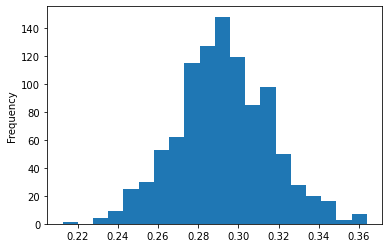

In [118]:
%matplotlib inline
import pandas as pd
pd.Series(deltas).plot.hist(bins=20)

#### Improved model B vs hulk

In [119]:
p_value, deltas = bootstrap_sample(predictions_b, hulk_predictions, y_dev_reduced)
print(p_value, p_value < 0.01)

Base difference: 0.7780784844384304 vs. 0.7672530446549392
0.214 False


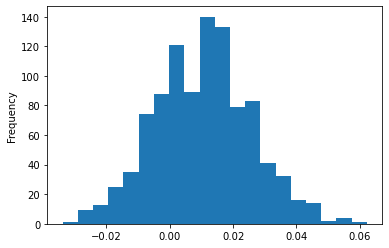

In [120]:
%matplotlib inline
import pandas as pd
pd.Series(deltas).plot.hist(bins=20)

#### Improved model A vs hulk

In [121]:
p_value, deltas = bootstrap_sample(predictions_a, hulk_predictions, y_dev_reduced)
print(p_value, p_value < 0.01)

Base difference: 0.7861975642760487 vs. 0.7672530446549392
0.091 False


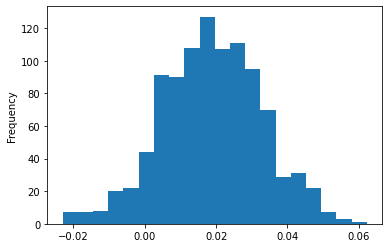

In [122]:
%matplotlib inline
import pandas as pd
pd.Series(deltas).plot.hist(bins=20)

#### What to improve?

The improved model by hyper-parameter tuning and reduction of dimensionality perform better than the dumb classifier, but not better than the standard model without hyper parameter tuning in a statistical signigicant way.

But how is it possible that the model with reduction of dimensionality performs better than the one without? The answer is that, when using dimensionality reduction, I used the best classifier for the dataset with all dimensions.

To improve the model even more, a solution would be to perform hyper parameter tuning for a different set reduced dimensions.

# 4.2 Structured Prediction (5pts)

*Adapt the Structured Perceptron to your sequence prediction task, and note the performance as baseline (2 pt).
Implement a suitable neural net architecture (in `keras`) on the data (2 pts). Compare the best performance of the  models (1 pt).*

### Create dataset using Topic Modelling

In order to generate the dataset for structured prediction, instead of manual labelling, I exploited the fact that LDA is a probabilistic model, instead of a deterministic one.

The idea is to run LDA several times to find two topics: if one of these two contains the word 'depression', then all the other words in the same topic are given the tag 'A'. The words in the other topic are given instead the tag 'B'. Only 20 words per topic are considered.

This process is repeated 5 times to tag random parts of the corpus.

The result is to label as 'A' words related to mental illness and as 'B' the words that fall in the other topic. Words that are in neither topics are labelled with a neutral tag 'O'. Words that are in both topics are randomly given 'A' or 'B'.

This automatic tagging is an attempt to create a training dataset for structured prediction. This being said, a dataset manually labelled with proper context to understand if a specific word relates or not to mental illness would definetely be a better training set.

In [31]:
import random

def generate_topics(num_topics, df=df_preprocessing['lemmatization_nuon_adj']):
    
    instances = df.apply(str.split).tolist()
    
    # shuffle instances
    random.shuffle(instances)
    
    phrases = Phrases(instances, min_count=5, threshold=1)
    instances_colloc = phrases[instances]

    dictionary = Dictionary(instances_colloc)
    dictionary.filter_extremes(no_below=50, no_above=0.3)
    
    ldacorpus = [dictionary.doc2bow(text) for text in instances]
    tfidfmodel = TfidfModel(ldacorpus)
    model_corpus = tfidfmodel[ldacorpus]

    # find chunksize to make about 200 updates
    num_passes = 10
    chunk_size = len(model_corpus) * num_passes/200
    
    dev_size = len(df)

    model = LdaMulticore(num_topics=num_topics, # number of topics
                         corpus=model_corpus[:dev_size], # what to train on 
                         id2word=dictionary, # mapping from IDs to words
                         workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                         passes=num_passes, # make this many passes over data
                         chunksize=chunk_size, # update after this many instances
                         alpha=0.5,
                         random_state=42)


    # transform the data into topic distros
    topic_corpus = model[model_corpus]

    # get the topic descriptions
    topic_sep = re.compile("0\.[0-9]{3}\*") # getting rid of useless formatting
    # extract a list of tuples with topic number and descriptors from the model
    model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                    for topic_no, model_topic in
                    model.print_topics(num_topics=num_topics, num_words=20)]

    descriptors = []
    for i, m in model_topics:
        print(i+1, ", ".join(m[:10]))
        descriptors.append(", ".join(m[:10]).replace('"', ''))
    
    return model_topics

In [32]:
# Split data randomly in 5 groups

data = df_preprocessing['lemmatization_nuon_adj'].copy()
data = data.sample(frac=1)

n_splits = 5
N = len(data)
size = int(N*(1/n_splits)) 

data_split_list = []

for i in range(n_splits):
    
    start_index = i*size
    end_index = (i+1)*size
    
    data_i = data[start_index:end_index]
    
    data_split_list.append(data_i)

In [33]:
len(data_split_list)

5

In [34]:
len(data_split_list[0])

1199

In [35]:
def clean_topics(topics):
    
    topic_1 = []

    for t in topics[0][1][:20]:
        topic_1.append(t[1:-1])
        
    topic_2 = []

    for t in topics[1][1][:20]:
        topic_2.append(t[1:-1])
        
    topic_mixed = list(set(topic_1) & set(topic_2))
    
    return topic_1, topic_2, topic_mixed

In [81]:
def check_good_topics(topic_1, topic_2, topic_mixed, topic_pilar = 'depression'):
    
    dict_topic = dict()

    if topic_pilar in topic_mixed:
        return dict_topic

    if topic_pilar not in topic_1+topic_2:
        return dict_topic

    if topic_pilar in topic_1:
        dict_topic['topic_1'] = 'A'
        dict_topic['topic_2'] = 'B'

    else:
        dict_topic['topic_1'] = 'B'
        dict_topic['topic_2'] = 'A'
        
    return dict_topic

In [84]:
def build_n_topic_models(n_splits=n_splits, num_topics=2):
    for i in range(n_splits):

        good_current_topic = False

        while not good_current_topic:

            print(f"Start iteration for topic number {i+1}")

            topics = generate_topics(num_topics)
            
            # TODO: generate topics on the subset of the df to get context?
            #topics = generate_topics(num_topics, data_split_list[i])

            topic_1, topic_2, topic_mixed = clean_topics(topics)
            dict_topic = check_good_topics(topic_1, topic_2, topic_mixed, topic_pilar = 'anxiety')

            if not dict_topic:
                print(f"\tCURRENT ITERATION FAILED: start again")

            else:
                good_current_topic = True
                print(f"\tDone")
                yield (topic_1, topic_2, topic_mixed, dict_topic)

In [83]:
topic_models = [(topic_1, topic_2, topic_mixed, dict_topic) for (topic_1, topic_2, topic_mixed, dict_topic) in build_n_topic_models()]

Start iteration for topic number 0
1 "anxiety", "week", "day", "anxious", "mental", "bad", "time", "lot", "health", "attack"
2 "life", "people", "friend", "thing", "time", "year", "day", "good", "tired", "happy"
	Done
Start iteration for topic number 1
1 "anxiety", "day", "bad", "depression", "attack", "thought", "anxious", "week", "pain", "night"
2 "friend", "people", "life", "thing", "good", "time", "year", "person", "job", "way"
	Done
Start iteration for topic number 2
1 "people", "life", "friend", "thing", "time", "good", "person", "way", "depression", "bad"
2 "anxiety", "day", "job", "night", "year", "time", "week", "anxious", "bad", "attack"
	Done
Start iteration for topic number 3
1 "anxiety", "life", "job", "time", "day", "year", "bad", "depression", "mental", "anxious"
2 "friend", "people", "good", "thing", "life", "time", "person", "relationship", "day", "way"
	Done
Start iteration for topic number 4
1 "life", "thing", "people", "bad", "time", "year", "parent", "thought", "da

In [85]:
topic_1, topic_2, topic_mixed, dict_topic = topic_models[0]

In [86]:
topic_1

['anxiety',
 'week',
 'day',
 'anxious',
 'mental',
 'bad',
 'time',
 'lot',
 'health',
 'attack',
 'night',
 'panic',
 'work',
 'issue',
 'month',
 'last',
 'thing',
 'help',
 'new',
 'hour']

In [87]:
dict_topic

{'topic_1': 'A', 'topic_2': 'B'}

In [88]:
def get_data(df, topic_model):
    
    topic_1, topic_2, topic_mixed, dict_topic = topic_model

    for post in df:
        
        words = []
        tags = []

        for word in post.split():

            if word in topic_mixed:

                # if in both topics, return a random tag
                tag = random.choice(list(dict_topic.values()))

            elif word in topic_1:
                tag = dict_topic['topic_1']

            elif word in topic_2:
                tag = dict_topic['topic_2']

            else:
                tag = '0'

            words.append(word)
            tags.append(tag)

        yield (words, tags)

In [89]:
instances_list = []

for i in range(n_splits):
    
    df_split = data_split_list[i]
    topic_model = topic_models[i]
    
    instances = [(words, tags) for (words, tags) in get_data(df_split, topic_model)]
    instances_list.append(instances)

In [90]:
len(instances_list)

5

In [91]:
instances_train = instances_list[0] + instances_list[1] + instances_list[2]
instances_test = instances_list[3] + instances_list[4] 

In [102]:
instances_train[3]

(['medication',
  'thought',
  'medication',
  'bipolar',
  'year',
  'lamictal',
  'last',
  'year',
  'concoction',
  'low',
  'dose',
  'med',
  'anxiety',
  'depression',
  'insurance',
  'abilify',
  'lamictal',
  'pocket',
  'cost',
  'expensive',
  'vraylar',
  'experience',
  'knowledge',
  'similar',
  'medication',
  'different',
  'medication',
  'combination',
  'high',
  'available',
  'lamictal',
  'mg',
  'option',
  'alternative',
  'vraylar',
  'lamictal',
  'lithium',
  'idea',
  'willing',
  'strong',
  'advice'],
 ['A',
  'A',
  'A',
  '0',
  'A',
  '0',
  'A',
  'B',
  '0',
  '0',
  '0',
  '0',
  'A',
  'A',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  'A',
  '0',
  'A',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0'])

In [92]:
import pickle

In [93]:
# Save instances

with open('instances_train.pkl', 'wb') as f:
    pickle.dump(instances_train, f)
    
with open('instances_test.pkl', 'wb') as f:
    pickle.dump(instances_test, f)

In [55]:
# Read instaces

'''
with open('instances_train.pkl', 'rb') as f:
    instances_train = pickle.load(f)
    
with open('instances_test.pkl', 'rb') as f:
    instances_test = pickle.load(f)
'''

"\nwith open('instances_train.pkl', 'rb') as f:\n    instances_train = pickle.load(f)\n    \nwith open('instances_test.pkl', 'rb') as f:\n    instances_test = pickle.load(f)\n"

### Structured Perceptron

In [56]:
from collections import defaultdict, Counter
import json
import re
import numpy as np
import sys
import pickle
import random

np.set_printoptions(precision=2)

users = re.compile('@[^ ]+')
numbers = re.compile('[0-9]')
urls = re.compile("(https?:\/\/)?(?:www\.|(?!www))?[^\s\.]+\.[^\s]{2,}|(www)?\.[^\s]+\.[^\s]{2,}")

In [75]:
class StructuredPerceptron(object):
    """
    implements a structured perceptron as described in Collins 2002,
    with updates from https://explosion.ai/blog/part-of-speech-pos-tagger-in-python
    """

    def __init__(self):
        """
        initialize model parameters
        """
        self.tags = set()
        self.feature_weights = defaultdict(lambda: defaultdict(float)) #feature_name -> tags -> weight
        self.weight_totals = defaultdict(lambda: defaultdict(float)) #feature_name -> tags -> weight
        self.timestamps = defaultdict(lambda: defaultdict(float)) #feature_name -> tags -> weight

        self.tag_dict = defaultdict(set) #word -> {tags}

        self.START = "__START__"
        self.END = "__END__"
        
        
    def normalize(self, word):
        """
        lowercase word, and replace numbers, user names, and URLs
        """
        return re.sub(urls, 'URL', re.sub(users, '@USER', re.sub(numbers, '0', word.strip().lower())))

    
    def evaluate(self, data_instances, method='greedy'):
        correct = 0
        total = 0
        for (words, tags) in data_instances:
            try:
                preds = self.predict(words, method=method)
            except IndexError:
                continue
                
            matches = sum(map(lambda x: int(x[0]==x[1]), zip(preds, tags)))
            correct += matches
            total += len(tags)
        return correct/total
        
    
    def fit(self, instances, dev_instances=None, iterations=10, learning_rate=0.25, inference='greedy', verbose=False):     
        
        for (words, tags) in instances:
            self.tags.update(set(tags))

            for word, tag in zip(words, tags):
                self.tag_dict[self.normalize(word)].add(tag)
        
            
        # iterate over data
        for iteration in range(1, iterations+1):
            correct = 0
            total = 0
            if verbose:
                print('Iteration {}'.format(iteration+1), file=sys.stderr, flush=True)
                print("*" * 15, file=sys.stderr, flush=True)

            random.shuffle(instances)
            for i, (words, tags) in enumerate(instances):
                if i > 0:
                    if i%1000==0:
                        print('%s'%i, file=sys.stderr, flush=True)
                    elif i%20==0:
                        print('.', file=sys.stderr, flush=True, end='')

                try:
                    prediction = self.predict(words, method=inference)
                except IndexError:
                    continue

                # derive global features
                global_gold_features, global_prediction_features = self.get_global_features(words, prediction, tags)
                                    
                # update weight vector:
                # 1. move closer to true tag
                for tag, fids in global_gold_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] += learning_rate * count

                # 2. move further from wrong tag
                for tag, fids in global_prediction_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] -= learning_rate * count
                        
                # compute training accuracy for this iteration
                correct += sum([int(predicted_tag == true_tag) for predicted_tag, true_tag in zip(prediction, tags)])
                total += len(tags)

                # output examples
                if verbose and i%1000==0:
                    print("current word accuracy:{:.2f}".format(correct/total))
                    print(list(zip(words, 
                                   [self.normalize(word) for word in words], 
                                   tags, 
                                   prediction)), file=sys.stderr, flush=True)
            
            print('\t{} features'.format(len(self.feature_weights)), file=sys.stderr, flush=True)
            print('\tTraining accuracy: {:.2f}\n'.format(correct/total), file=sys.stderr, flush=True)
            if dev_instances:
                print('\tDevelopment accuracy: {:.2f}\n'.format(self.evaluate(dev_instances, method=inference)), file=sys.stderr, flush=True)
         
        # average weights
        for feature, tags in self.feature_weights.items():
            for tag in tags:
                total = self.weight_totals[feature][tag]
                total += (iterations - self.timestamps[feature][tag]) * self.feature_weights[feature][tag]
                averaged = round(total / float(iterations), 3)
                self.feature_weights[feature][tag] = averaged


    def get_features(self, word, previous_tag2, previous_tag, words, i):
        """
        get all features that can be derived from the word and previous tags
        """
        prefix = word[:3]
        suffix = word[-3:]

        features = {
                    'PREFIX={}'.format(prefix),
                    'SUFFIX={}'.format(suffix),
                    'LEN<=3={}'.format(len(word)<=3),
                    'FIRST_LETTER={}'.format(word[0]),
                    'WORD={}'.format(word),
                    'NORM_WORD={}'.format(words[i]),
                    'PREV_WORD={}'.format(words[i-1]),
                    'PREV_WORD_PREFIX={}'.format(words[i-1][:3]),
                    'PREV_WORD_SUFFIX={}'.format(words[i-1][-3:]),
                    'PREV_WORD+WORD={}+{}'.format(words[i-1], words[i]),
                    'NEXT_WORD={}'.format(words[i+1]),
                    'NEXT_WORD_PREFIX={}'.format(words[i+1][:3]),
                    'NEXT_WORD_SUFFIX={}'.format(words[i+1][-3:]),
                    'WORD+NEXT_WORD={}'.format(word, words[i+1]),
                    'NEXT_2WORDS={}+{}'.format(words[i+1], words[i+2]),
                    'PREV_TAG={}'.format(previous_tag),                 # previous tag
                    'PREV_TAG2={}'.format(previous_tag2),                 # two-previous tag
                    'PREV_TAG_BIGRAM={}+{}'.format(previous_tag2, previous_tag),  # tag bigram
                    'PREV_TAG+WORD={}+{}'.format(previous_tag, word),            # word-tag combination
                    'PREV_TAG+PREFIX={}_{}'.format(previous_tag, prefix),        # prefix and tag
                    'PREV_TAG+SUFFIX={}_{}'.format(previous_tag, suffix),        # suffix and tag
                    'WORD+TAG_BIGRAM={}+{}+{}'.format(word, previous_tag2, previous_tag),
                    'SUFFIX+2TAGS={}+{}+{}'.format(suffix, previous_tag2, previous_tag),
                    'PREFIX+2TAGS={}+{}+{}'.format(prefix, previous_tag2, previous_tag),
                    'BIAS'
            }
        return features
    
    
    def get_global_features(self, words, predicted_tags, true_tags):
        '''
        sum up local features
        '''
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        global_gold_features = defaultdict(lambda: Counter())
        global_prediction_features = defaultdict(lambda: Counter())

        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START
        
        for j, (word, predicted_tag, true_tag) in enumerate(zip(words, predicted_tags, true_tags)):
            # get the predicted features. NB: use j+1, since context is longer than words
            prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)

            # update feature correlation with true and predicted tag
            global_prediction_features[predicted_tag].update(prediction_features)
            global_gold_features[true_tag].update(prediction_features)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

        return global_gold_features, global_prediction_features
            
    
    def get_scores(self, features):
        """
        predict scores for each tag given features
        """
        scores = defaultdict(float)
        
        # add up the scores for each tag
        for feature in features:
            if feature not in self.feature_weights:
                continue
            weights = self.feature_weights[feature]
            for tag, weight in weights.items():
                scores[tag] += weight

        # return tag scores
        if not scores:
            # if there are no scores (e.g., first iteration),
            # simply return the first tag with score 1
            scores[list(self.tags)[0]] = 1
        
        return scores


    def predict(self, words, method='greedy'):
        '''
        predict tags using one of two methods
        '''
        if method == 'greedy':
            return self.predict_greedy(words)
        elif method == 'viterbi':
            return self.predict_viterbi(words)


    def predict_viterbi(self, words):
        '''
        predict using Viterbi decoding
        '''
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        N = len(words)
        M = len(self.tags) #number of tags
        tags = sorted(self.tags)

        # create trellis of size M (number of tags) x N (sentence length)
        Q = np.ones((M, N)) * float('-Inf')
        backpointers = np.ones((M, N), dtype=np.int16) * -1 #backpointers

        # initialize probs for tags j at position 1 (first word)
        features = self.get_features(words[0], self.START, self.START, context, 1)
        scores = self.get_scores(features)
        allowed_initial_tags = self.tag_dict[context[1]]

        for j in range(M):
            if not allowed_initial_tags or tags[j] in allowed_initial_tags:
                Q[j,0] = scores[tags[j]]

        # filling the lattice, for every position and every tag find viterbi score Q
        for i in range(1, N):
            allowed_tags = self.tag_dict[context[i+1]]

            # for every previous tag
            for j in range(M):
                best_score = 0.0#float('-Inf')
                prev_tag = tags[j]

                # skip impossible tags
                allowed_previous_tags = self.tag_dict[context[i]]
                if allowed_previous_tags and prev_tag not in allowed_previous_tags:
                    continue

                best_before = Q[j,i-1] # score of previous tag

                # for every possible pre-previous tag
                for k in range(M):
                    if i == 1:
                        prev2_tag = self.START
                    else:
                        prev2_tag = tags[k]
                        # skip impossible tags
                        allowed_previous2_tags = self.tag_dict[context[i-1]]
                        if allowed_previous2_tags and prev2_tag not in allowed_previous2_tags:
                            continue

                    # get features of word i with the two previous tags
                    features = self.get_features(words[i], prev2_tag, prev_tag, context, i+1)
                    scores = self.get_scores(features)

                    # update best score
                    for t in range(M):
                        tag = tags[t]
                        # if word is unknown, use all tags, otherwise allowed ones
                        if not allowed_tags or tag in allowed_tags:
                            tag_score = best_before + scores[tag]

                            if tag_score > best_score:
                                Q[t,i] = tag_score
                                best_score = tag_score
                                backpointers[t,i] = j

        # final best
        best_id = Q[:,-1].argmax()

        # print best tags in reverse order
        predtags = [tags[best_id]]

        for i in range(N-1,0,-1):
            idx = backpointers[best_id, i]
            predtags.append(tags[idx])
            best_id = idx

        #return reversed predtags
        return predtags[::-1]         

    
    def predict_greedy(self, words):
        '''
        greedy prediction
        '''
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]
                
        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START

        out = []

        for j, word in enumerate(words):
            # for unambiguous words, just look up the tag
            predicted_tag = list(self.tag_dict[context[j+1]])[0] if len(self.tag_dict[context[j+1]]) == 1 else None

            if not predicted_tag:
                # get the predicted features. NB: use j+1, since context is longer than words
                prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)
                scores = self.get_scores(prediction_features)
                
                # predict the current tag
                predicted_tag = max(scores, key=scores.get)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

            out.append(predicted_tag)

        return out
        

    def save(self, file_name):
        """
        save model as pickle file
        """
        print("saving model...", end=' ', file=sys.stderr)
        with open(file_name, "wb") as model:
            # pickle cannot save default_dictionaries
            # => make copy and turn into regular dictionaries
            save_feature_weights = defaultdict(lambda: defaultdict(float))
            save_feature_weights.update(self.feature_weights)
            save_tag_dict = defaultdict(set)
            save_tag_dict.update(self.tag_dict)

            save_feature_weights.default_factory = None
            save_tag_dict.default_factory = None
            pickle.dump((save_feature_weights, save_tag_dict, self.tags),
                     model, -1)
        print("done", file=sys.stderr)


    def load(self, file_name):
        """
        load model from pickle file
        """
        print("loading model...", end=' ', file=sys.stderr)
        with open(file_name, 'rb') as model:
            try:
                parameters = pickle.load(model)
            except IOError:
                msg = ("No such model file.")
                raise MissingCorpusError(msg)

            feature_weights, tag_dict, tags = parameters
            self.tags = tags

            # pickle cannot store defaultdicts, so we need a 2-step process
            # 1. initialize
            self.feature_weights = defaultdict(lambda: defaultdict(float))
            self.tag_dict = defaultdict(set)
            
            # 2. update
            self.feature_weights.update(feature_weights)
            self.tag_dict.update(tag_dict)
        print("done", file=sys.stderr)
        return None

In [94]:
sp = StructuredPerceptron()
inference_method = 'greedy'
%time sp.fit(instances_train, instances_test, iterations=10, inference=inference_method)

sp.save('model_greedy.pickle')

.................................................1000
.................................................2000
.................................................3000
.............................	314347 features
	Training accuracy: 0.91

	Development accuracy: 0.84

.................................................1000
.................................................2000
.................................................3000
.............................	319983 features
	Training accuracy: 0.92

	Development accuracy: 0.86

.................................................1000
.................................................2000
.................................................3000
.............................	322707 features
	Training accuracy: 0.92

	Development accuracy: 0.85

.................................................1000
.................................................2000
.................................................3000
.............................	324155 features
	Tr

CPU times: user 2min 11s, sys: 2.13 s, total: 2min 13s
Wall time: 2min 20s


saving model... done


In [76]:
sp2 = StructuredPerceptron()
inference_method = 'viterbi'
%time sp2.fit(instances_train, instances_test, iterations=10, inference=inference_method)

sp2.save('model_viterbi.pickle')

.................................................1000
.................................................2000
.................................................3000
.............................	315151 features
	Training accuracy: 0.86

	Development accuracy: 0.82

.................................................1000
.................................................2000
.................................................3000
.............................	321209 features
	Training accuracy: 0.87

	Development accuracy: 0.82

.................................................1000
.................................................2000
.................................................3000
.............................	323590 features
	Training accuracy: 0.87

	Development accuracy: 0.82

.................................................1000
.................................................2000
.................................................3000
.............................	324881 features
	Tr

CPU times: user 3min 46s, sys: 2.06 s, total: 3min 48s
Wall time: 3min 51s


saving model... done


In [95]:
print(sp.predict('My life is so amazing!'.split(), method='greedy'))

['0', 'B', 'A', '0', '0']


In [103]:
print(sp.predict('The medication is not working'.split(), method='greedy'))

['A', 'A', '0', '0', '0']


### Structured  Prediction with LSTMs

In [104]:
# collect known word tokens and tags

wordset, tagset = set(), set()
train_instances = instances_train
for (words, tags) in train_instances:
    tagset.update(set(tags))
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words
 
tag2int = {tag: i + 1 for i, tag in enumerate(sorted(tagset))}
tag2int[PAD] = 0
# to translate it back
int2tag = {i:tag for tag, i in tag2int.items()}


def convert2ints(instances):
    result = []
    for (words, tags) in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        # replace tags with int
        tag_ints = [tag2int[tag] for tag in tags]
        result.append((word_ints, tag_ints))
    return result        

In [105]:
# get some test data
test_instances = instances_test

# apply integer mapping
train_instances_int = convert2ints(train_instances)
test_instances_int = convert2ints(test_instances)

# separate the words from the tags
train_sentences, train_tags = zip(*train_instances_int) 
test_sentences, test_tags = zip(*test_instances_int) 

print(train_instances[0][0])
print(train_sentences[0])
print(train_instances[0][1])
print(train_tags[0])

['annoying', 'shit', 'quiet', 'self', 'destruction', 'other', 'aware', 'trigger', 'splitting', 'able', 'block', 'sure', 'emotion', 'time', 'couple', 'people', 'first', 'reaction', 'stigma', 'world', 'manipulative', 'pos', 'much', 'other', 'people', 'mental', 'illness', 'act', 'ill', 'bpd', 'complex', 'good', 'mask', 'illness', 'scared', 'people', 'crazy', 'huge', 'stigma', 'upset', 'time', 'day', 'stigma', 'big', 'bad', 'today']
[488, 7668, 6825, 7514, 2365, 5974, 761, 8892, 8055, 160, 1026, 8378, 2850, 8703, 1969, 6217, 3316, 6903, 8162, 9619, 5192, 6488, 5570, 5974, 6217, 5329, 4286, 232, 4279, 1130, 1743, 3710, 5226, 4286, 7414, 6217, 2014, 4168, 8162, 9221, 8703, 2184, 8162, 952, 787, 8749]
['0', 'B', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'B', '0', 'B', '0', '0', '0', 'B', '0', '0', 'B', '0', 'B', 'A', '0', '0', '0', '0', '0', 'B', '0', '0', '0', 'B', '0', '0', '0', '0', 'A', 'B', '0', '0', 'A', '0']
[1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1

In [106]:
# get longest training sentence and add 5
MAX_LENGTH = len(max(train_sentences, key=len)) + 5
print(MAX_LENGTH)

548


In [109]:
from keras.preprocessing.sequence import pad_sequences
 
# add special padding at the end of every instance, up to MAX_LENGTH
train_sentences = pad_sequences(train_sentences, maxlen=MAX_LENGTH, padding='post')
test_sentences = pad_sequences(test_sentences, maxlen=MAX_LENGTH, padding='post')
train_tags = pad_sequences(train_tags, maxlen=MAX_LENGTH, padding='post')
test_tags = pad_sequences(test_tags, maxlen=MAX_LENGTH, padding='post')
 
print(train_sentences[0])
print(train_tags[0])

[ 488 7668 6825 7514 2365 5974  761 8892 8055  160 1026 8378 2850 8703
 1969 6217 3316 6903 8162 9619 5192 6488 5570 5974 6217 5329 4286  232
 4279 1130 1743 3710 5226 4286 7414 6217 2014 4168 8162 9221 8703 2184
 8162  952  787 8749    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [110]:
from keras.models import Model
from keras.layers import Input, Embedding
from keras.layers import Bidirectional, LSTM
from keras.layers import Dropout, Dense, Activation
import numpy as np

# Set a random seed for reproducibility
np.random.seed(0)

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')

embeddings = Embedding(input_dim=len(word2int), 
                       output_dim=128, 
                       mask_zero=True, 
                       name='embeddings')(inputs)
lstm = LSTM(units=256,
              return_sequences=True,
              name="LSTM")(embeddings)

dropout = Dropout(0.3, name='dropout')(lstm)
lstm_out = Dense(len(tag2int), name='output')(dropout)
output = Activation('softmax', name='softmax')(lstm_out)

model = Model(inputs=[inputs], outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        [(None, 548)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 548, 128)          1247616   
_________________________________________________________________
LSTM (LSTM)                  (None, 548, 256)          394240    
_________________________________________________________________
dropout (Dropout)            (None, 548, 256)          0         
_________________________________________________________________
output (Dense)               (None, 548, 4)            1028      
_________________________________________________________________
softmax (Activation)         (None, 548, 4)            0         
Total params: 1,642,884
Trainable params: 1,642,884
Non-trainable params: 0
___________________________________________________

In [111]:
from keras.utils import to_categorical

train_tags_1hot = to_categorical(train_tags, len(tag2int))
test_tags_1hot = to_categorical(test_tags, len(tag2int))

# originally 50 tag IDs
print(train_tags[0])
# now 50 rows with 13 columns
print(train_tags_1hot[0].shape)
# the 1-hot encoding of tag ID 7
print(train_tags_1hot[0])

[1 3 1 1 1 1 1 1 1 1 1 1 1 3 1 3 1 1 1 3 1 1 3 1 3 2 1 1 1 1 1 3 1 1 1 3 1
 1 1 1 2 3 1 1 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [112]:
batch_size = 16
epochs = 5

# compile the model we have defined above
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

# run training and capture ouput log
history = model.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/5
180/180 [==============================] - 143s 773ms/step - loss: 0.0537 - accuracy: 0.7895 - val_loss: 0.0107 - val_accuracy: 0.9204
Epoch 2/5
180/180 [==============================] - 126s 700ms/step - loss: 0.0105 - accuracy: 0.9224 - val_loss: 0.0097 - val_accuracy: 0.9204
Epoch 3/5
180/180 [==============================] - 127s 707ms/step - loss: 0.0096 - accuracy: 0.9246 - val_loss: 0.0099 - val_accuracy: 0.9172
Epoch 4/5
180/180 [==============================] - 127s 704ms/step - loss: 0.0092 - accuracy: 0.9251 - val_loss: 0.0097 - val_accuracy: 0.9199
Epoch 5/5
180/180 [==============================] - 126s 702ms/step - loss: 0.0087 - accuracy: 0.9298 - val_loss: 0.0097 - val_accuracy: 0.9177


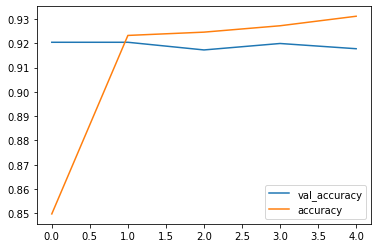

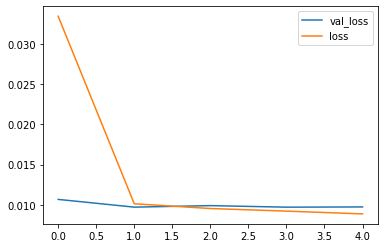

In [113]:
%matplotlib inline
import pandas as pd
import seaborn

df = pd.DataFrame(history.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

In [114]:
loss, accuracy = model.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

150/150 [==============================] - 27s 171ms/step - loss: 0.0282 - accuracy: 0.8665
Test loss: 0.02824137732386589
Test accuracy: 0.8664929270744324


In [119]:
strange_sentences = ['The medication is not working'.split(),
                     "anxiety killing depression".split()
                    ]
# convert to integers
strange_sentences_int = [[word2int.get(word, 1) for word in sentence] for sentence in strange_sentences]
# add padding
strange_sentences_int = pad_sequences(strange_sentences_int, maxlen=MAX_LENGTH, padding='post')

predictions = model.predict(strange_sentences_int)
print(predictions, predictions.shape)

[[[1.64e-01 4.66e-01 1.83e-01 1.87e-01]
  [5.40e-03 4.15e-01 5.54e-01 2.60e-02]
  [1.34e-03 9.66e-01 2.42e-02 8.85e-03]
  ...
  [2.03e-04 9.94e-01 4.37e-04 5.35e-03]
  [2.03e-04 9.94e-01 4.37e-04 5.35e-03]
  [2.03e-04 9.94e-01 4.37e-04 5.35e-03]]

 [[2.18e-04 8.19e-03 9.78e-01 1.33e-02]
  [9.71e-05 9.96e-01 9.24e-04 2.49e-03]
  [1.51e-03 2.07e-01 2.49e-01 5.43e-01]
  ...
  [1.51e-03 2.07e-01 2.49e-01 5.43e-01]
  [1.51e-03 2.07e-01 2.49e-01 5.43e-01]
  [1.51e-03 2.07e-01 2.49e-01 5.43e-01]]] (2, 548, 4)


In [120]:
def inverse_transform(sentences, predictions):
    output = []
    for sentence, prediction in zip(sentences, predictions):
        # find the index of the highest-scoring tag and translate it back
        token_sequence = [int2tag[np.argmax(prediction[i])] for i in range(len(sentence))]
        output.append(token_sequence)
    return output

print(list(zip(strange_sentences, inverse_transform(strange_sentences, predictions))))

[(['The', 'medication', 'is', 'not', 'working'], ['0', 'A', '0', '0', '0']), (['anxiety', 'killing', 'depression'], ['A', '0', 'B'])]


The performance of the LSTM model on the validation sets is above 90%, while for the structured perceptron it is a bit lower.

This being said, in order to compare the performances, it would be better to have a test set that neither model has seen during training and to perform bootstrap sampling on the the predictions to determine if the differences are statistically significant.